In [97]:
import numpy as np
import pandas as pd

import shap

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager as fm, rcParams
import seaborn as sns

import xgboost as xgb
from catboost import CatBoostClassifier

from scipy import interp, stats
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
#from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.metrics import log_loss, brier_score_loss
from sklearn.metrics import balanced_accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.metrics import precision_recall_curve

from PIL import Image
from io import BytesIO
import time
import datetime
import re, sys, glob, os, pydot
import warnings
warnings.filterwarnings('ignore')
import pickle as pkl

from sklearn.tree import export_graphviz
from IPython import display
%config Completer.use_jedi = False

In [2]:
print ('버전: ', mpl.__version__)
print ('설치 위치: ', mpl.__file__)
print ('설정 위치: ', mpl.get_configdir())
print ('캐시 위치: ', mpl.get_cachedir())
print (plt.rcParams['font.serif'])

plt.rcParams["font.family"] = "serif"
plt.rcParams['font.serif']='Times New Roman'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.dpi"] = 150
rcParams["figure.facecolor"] = 'w'
print (plt.rcParams['font.family'])
print (plt.rcParams['font.serif'])


버전:  3.3.4
설치 위치:  /usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py
설정 위치:  /home/hahnyi/.config/matplotlib
캐시 위치:  /home/hahnyi/.cache/matplotlib
['DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Times New Roman', 'Times', 'Palatino', 'Charter', 'serif']
['serif']
['Times New Roman']


In [3]:
def adjusted_classes(y_scores, thr):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= thr else 0 for y in y_scores]

In [4]:
# def inverse_adjusted_classes(y_scores, thr):
#     """
#     This function adjusts class predictions based on the prediction threshold (t).
#     Will only work for binary classification problems.
#     """
#     return [0 if y >= thr else 1 for y in y_scores]

##### Regularized Logistic Regression Classifier

In [5]:
def rlr_clf(XTrain, yTrain, XTest, yTest) :
    
    kappa_scorer = make_scorer(cohen_kappa_score)
    base_fpr = np.linspace(0, 1, 101)
    grids={'C': np.logspace(-2,2,10), 
           'penalty':['l2'], 
           'solver': ['lbfgs'],
           'max_iter': [1000],
           'fit_intercept': [True],
           'tol': [1e-4], 
           'class_weight' :['balanced']}# l1 lasso l2 ridge
    logreg=LogisticRegression()
    logreg_cv=GridSearchCV(logreg, grids, cv=StratifiedKFold(),
                           scoring=kappa_scorer, verbose=0,
                           #scoring='recall', verbose=0,
                           n_jobs=24, pre_dispatch='2*n_jobs')
    grid_result = logreg_cv.fit(XTrain,yTrain)
    #print('tuned hpyerparameters :(best parameters) ',logreg_cv.best_params_)
    clf_rlr = LogisticRegression(C = grid_result.best_params_['C'], max_iter=5000,
                                penalty = grid_result.best_params_['penalty'],
                                tol = 1e-4, class_weight = 'balanced').fit(XTrain, yTrain)
    #clf_rlr = clf_rlr.fit(XTrain, yTrain)
    yPred = clf_rlr.predict_proba(XTest)
    fpr, tpr, thr = roc_curve(yTest, yPred[:,1])
    J_youden = tpr - fpr
    thr_opt = thr[np.argmax(J_youden)]
    aucs = auc(fpr, tpr)
    #y_pred = adjusted_classes(y_scores, 0.5)
    #confusion_matrix(y_test, y_pred)
    imps = clf_rlr.coef_[0]
    logloss = log_loss(yTest, yPred[:,1])
    bscoreloss = brier_score_loss(yTest, yPred[:,1])
    tpr_more = interp(base_fpr, fpr, tpr)
    tpr_more[0] = 0.0
    return fpr, tpr, thr, thr_opt, tpr_more, aucs, logloss, bscoreloss, imps, clf_rlr

##### Random Forest Classifier

In [6]:
def rf_clf(XTrain, yTrain, XTest, yTest) :
    kappa_scorer = make_scorer(cohen_kappa_score)
    base_fpr = np.linspace(0, 1, 101)
    params = {'criterion': ('gini', 'entropy'), 
              'n_estimators': np.arange(20, 1000, 50), 
              'max_depth': [6, 9, 12], 
              'min_samples_leaf': [3, 6, 9], 
              'min_samples_split': [3, 6, 9, 12],
              'max_features': ['log2'],
              'min_impurity_decrease' : [0.0005], 
              'class_weight': ['balanced']}
    grid = GridSearchCV(RandomForestClassifier(random_state=64, class_weight = 'balanced'),
                      params, scoring=kappa_scorer, #scoring = 'recall', 
                      cv=StratifiedKFold(), n_jobs = 24, pre_dispatch="2*n_jobs")
    grid_result = grid.fit(XTrain, yTrain)

    clf_rf = RandomForestClassifier(n_estimators=grid_result.best_params_['n_estimators'], 
                                    criterion=grid_result.best_params_['criterion'], 
                                    random_state=64, class_weight = 'balanced').fit(XTrain, yTrain)
    yPred = clf_rf.predict_proba(XTest)
    fpr, tpr, thr = roc_curve(yTest, yPred[:,1])
    J_youden = tpr - fpr
    thr_opt = thr[np.argmax(J_youden)]
    aucs = auc(fpr, tpr)
    imps = clf_rf.feature_importances_
    logloss = log_loss(yTest, yPred[:,1])
    bscoreloss = brier_score_loss(yTest, yPred[:,1])
    tpr_more = interp(base_fpr, fpr, tpr)
    tpr_more[0] = 0.0
    return fpr, tpr, thr, thr_opt, tpr_more, aucs, logloss, bscoreloss, imps, clf_rf

##### XGBoost Classifier

In [7]:
def xgboost_clf(XTrain, yTrain, XTest, yTest) :
    
    kappa_scorer = make_scorer(cohen_kappa_score)
    base_fpr = np.linspace(0, 1, 101)
    params={'eta':[0.05, 0.15, 0.2],
            'n_estimators': [100, 120, 140, 160, 210, 240], 
            'max_depth':[5, 6, 7, 9, 11],
            'subsample': [0.7, 0.8, 0.9], 
            'scale_pos_weight':[43.5], 
            'gpu_id': ['0']}

    clf_xgb = xgb.XGBClassifier(tree_method='gpu_hist', use_label_encoder = False, 
                                objective='binary:logistic', eval_metric='logloss')
    grid_search = GridSearchCV(clf_xgb, params, scoring=kappa_scorer, #scoring = 'recall', 
                               cv=StratifiedKFold(), n_jobs=36)
    grid_search = grid_search.fit(XTrain, yTrain)
    best_parameters=grid_search.best_estimator_.get_params()
    clf_xgb = xgb.XGBClassifier(**best_parameters)
    clf_xgb.fit(XTrain, yTrain)
    #xgb.plot_importance(clf_xgb, title = "top 10 features", max_num_features=10)
    imps = clf_xgb.feature_importances_
    yPred = clf_xgb.predict_proba(XTest)
    fpr, tpr, thr = roc_curve(yTest, yPred[:,1])
    J_youden = tpr - fpr
    thr_opt = thr[np.argmax(J_youden)]
    aucs = auc(fpr, tpr)
    #y_pred = adjusted_classes(y_scores, 0.5)
    #confusion_matrix(yTest, y_pred)
    logloss = log_loss(yTest, yPred[:,1])
    bscoreloss = brier_score_loss(yTest, yPred[:,1])
    tpr_more = interp(base_fpr, fpr, tpr)
    tpr_more[0] = 0.0
    return fpr, tpr, thr, thr_opt, tpr_more, aucs, logloss, bscoreloss, imps, clf_xgb

#### CatBoost Classifier

In [8]:
def catboost_clf(XTrain, yTrain, XTest, yTest) :
    
    kappa_scorer = make_scorer(cohen_kappa_score)
    base_fpr = np.linspace(0, 1, 101)
    
    params = {'learning_rate': [0.01, 0.05],
              'depth': [4, 7, 8, 12],
              #'l2_leaf_reg': [3, 6, 9],
              #'subsample' : [0.5, 0.8, 1],
              #'leaf_estimation_iterations': [10, 20], 
              'loss_function': ['Logloss'], 
              #'max_leaves': [64, 128, 256],
              'eval_metric': ['AUC']}
    
    clf_cat = CatBoostClassifier(iterations=300, task_type="GPU", devices='0', verbose=False)
    #clf_cat = CatBoostClassifier(iterations=250, task_type="GPU", devices='2')
    grid_search = RandomizedSearchCV(clf_cat, params, scoring=kappa_scorer, #scoring = 'recall', 
                                      cv=StratifiedKFold(), n_jobs=1).fit(XTrain, yTrain)
    best_parameters=grid_search.best_estimator_.get_params()
    clf_cat = CatBoostClassifier(**best_parameters)
    clf_cat.fit(XTrain, yTrain)
    #xgb.plot_importance(clf_xgb, title = "top 10 features", max_num_features=10)
    imps = clf_cat.feature_importances_
    yPred = clf_cat.predict_proba(XTest)
    fpr, tpr, thr = roc_curve(yTest, yPred[:,1])
    J_youden = tpr - fpr
    thr_opt = thr[np.argmax(J_youden)]
    aucs = auc(fpr, tpr)
    #y_pred = adjusted_classes(y_scores, 0.5)
    #confusion_matrix(yTest, y_pred)
    logloss = log_loss(yTest, yPred[:,1])
    bscoreloss = brier_score_loss(yTest, yPred[:,1])
    tpr_more = interp(base_fpr, fpr, tpr)
    tpr_more[0] = 0.0
    return fpr, tpr, thr, thr_opt, tpr_more, aucs, logloss, bscoreloss, imps, clf_cat

##### Running all algorithms with gridsearchcv. It takes almost one day.

In [9]:
tmp = pd.read_csv("/workspace/data/imputed_data/prognostic_neuro_at_ROSC_imputed_data01.csv")
tmp.columns

Index(['Age', 'Total_collapse_duration', 'NO_FLOW_TIME',
       'Resuscitation_duration', 'EPINEPHRINE_MG', 'EC_HOSPITAL_C',
       'EC_HOSPITAL_J', 'ROSC_VS_SBP', 'ROSC_VS_DBP', 'ROSC_VS_HR',
       'ROSC_VS_TEMP', 'ABG_PH', 'ABG_PACO2', 'ABG_PAO2', 'ABG_HCO3',
       'ABG_O2SAT', 'HBA1C', 'BLOOD_GLUCOSE', 'LACTATE', 'PRO_BNP',
       'TROPONIN_1ST_DAY_I', 'PLATELETS_1D', 'BILIRUBIN_1D', 'CREATININE_1D',
       'SEX', 'WITNESSED', 'WITNESSED_CAT', 'BYSTANDER_CPR',
       'PREHOSPITAL_INITIAL_RHYTHM', 'PREHOSPITAL_Initial_rhythm_Shockable',
       'INITIAL_RHYTHM_HOSPITAL', 'HOSPITAL_Initial_rhythm_Shockable',
       'MEDICAL_HISTORY', 'previous_AMI_2', 'chronic_heart_failure_5',
       'hypertension_7', 'diabetes_8', 'renal_dz_11', 'Any_No_flow_time',
       'CARDIAC_ARREST_CAUSE', 'Arrest_Cause_Cardiac',
       'CARDIAC_ARREST_LOCATION', 'ARRIVAL_STATUS', 'BYSTANDER_AED', 'AIRWAY',
       'EC_EMS', 'INTUBATION', 'MECHANICAL_CPR', 'CARDIAC_ARREST_CAUSE_TYPE',
       'LEAD_ECG_TYPE', '

In [ ]:
start = time.time()
enc = OneHotEncoder()
# fprs, tprs, thrs, aucs
base_fpr = np.linspace(0, 1, 101)
swap_fprs = []
swap_tprs = []
swap_tpr_mores = []
swap_thrs = []
swap_thr_opts = []
swap_aucs = []

rlr_fprs = []
rlr_tprs = []
rlr_tpr_mores = []
rlr_thrs = []
rlr_thr_opts = []
rlr_aucs = []

rf_fprs = []
rf_tprs = []
rf_tpr_mores = []
rf_thrs = []
rf_thr_opts = []
rf_aucs = []

xgb_fprs = []
xgb_tprs = []
xgb_tpr_mores = []
xgb_thrs = []
xgb_thr_opts = []
xgb_aucs = []

cbc_fprs = []
cbc_tprs = []
cbc_tpr_mores = []
cbc_thrs = []
cbc_thr_opts = []
cbc_aucs = []

en_fprs = []
en_tprs = []
en_tpr_mores = []
en_thrs = []
en_thr_opts = []
en_aucs = []

# log_loss
swap_log_loss = []
rlr_log_loss = []
rf_log_loss = []
xgb_log_loss = []
cbc_log_loss = []
en_log_loss = []

# brier_score_loss
swap_brier_loss = []
rlr_brier_loss = []
rf_brier_loss = []
xgb_brier_loss = []
cbc_brier_loss= []
en_brier_loss = []

# classifiers
rlr_clfs = []
rf_clfs = []
xgb_clfs = []
cbc_clfs = []
en_clfs = []

# feature importances
rlr_imps = [] 
# ann_imps = []
rf_imps = []
xgb_imps = []
cbc_imps = []
#svc_imps = []

# Testsets saved
XTests = []
yTests = []
swapTest = []

files = glob.glob("/workspace/data/imputed_data/prognostic_neuro_at_ROSC_imputed_data*.csv")
files.sort()
for i, ifile in enumerate(files) :
    print(ifile)
    df = pd.read_csv(ifile, low_memory=False)
    df = df.replace({'Good_neurologic_6M_MRC': {0: 0, 2:0, 1:1}})
    # datasets for feature selections 
    X = np.array(df.loc[:,'Age':'ECPR'])
    y = np.array(df.loc[:,'Good_neurologic_6M_MRC'])
    swap_score = np.array(df.loc[:,'SWAP_Score'])

    nsplits = 5
    seeds = [131]
    for j in range(len(seeds)) :
        #print ("{} {} th loop".format(i, j))
        skf = StratifiedKFold(n_splits = nsplits, shuffle = True, 
                              random_state=seeds[j])
        
        for train_index, test_index in skf.split(X,y):
            XTrain, XTest = X[train_index], X[test_index]
            yTrain, yTest = y[train_index], y[test_index]
            unique, counts = np.unique(yTrain, return_counts=True)
#             print("Train, i =", i, "j =", j, dict(zip(unique, counts)))
            unique, counts = np.unique(yTest, return_counts=True)
#             print("Test, i =", i, "j =", j, dict(zip(unique, counts)))
            #print(XTrain.shape, yTrain.shape, XTest.shape, yTest.shape)
            XTests.append(XTest)
            yTests.append(yTest)
            
            swap_train, swap_test = swap_score[train_index], swap_score[test_index]
            swapTest.append(swap_test)
            swap_test = 4 - swap_test
            # SWAP -----------------------------------
            fpr, tpr, thr = roc_curve(yTest, swap_test)
            swap_thrs.append(thr)
            J_youden = tpr - fpr
            thr_opt = thr[np.argmax(J_youden)]
            swap_thr_opts.append(thr_opt)
            swap_fprs.append(fpr)
            swap_tprs.append(tpr)
            swap_aucs.append(auc(fpr, tpr))
            threshold = 0
            ypred_swap = adjusted_classes(swap_test, threshold)
            swap_log_loss.append(log_loss(yTest, swap_test))
            #swap_log_loss.append(log_loss(yTest, ypred_swap))
            swap_brier_loss.append(brier_score_loss(yTest, ypred_swap))
            swap_tpr_more = interp(base_fpr, fpr, tpr)
            swap_tpr_more[0] = 0.0
            swap_tpr_mores.append(swap_tpr_more)
            
            
            # regularized logistic regression classifier
            fpr, tpr, thr, thr_opt, tpr_more, aucs, logloss, bscoreloss, imps, clf1_rlr = \
                                                              rlr_clf(XTrain, yTrain, XTest, yTest)
            rlr_fprs.append(fpr)
            rlr_tprs.append(tpr)
            rlr_tpr_mores.append(tpr_more)
            rlr_thrs.append(thr)
            rlr_thr_opts.append(thr_opt)
            rlr_aucs.append(aucs)
            rlr_log_loss.append(logloss)
            rlr_brier_loss.append(bscoreloss)
            rlr_imps.append(imps)
            rlr_clfs.append(clf1_rlr)
            yPred_rlr = clf1_rlr.predict_proba(XTest)
            #print("rlr", tpr.shape, aucs, logloss, bscoreloss, imps, clf1_rlr)
                        
            # random forest classifier
            fpr, tpr, thr, thr_opt, tpr_more, aucs, logloss, bscoreloss, imps, clf2_rf = \
                                                             rf_clf(XTrain, yTrain, XTest, yTest)
            rf_fprs.append(fpr)
            rf_tprs.append(tpr)
            rf_tpr_mores.append(tpr_more)
            rf_thrs.append(thr)
            rf_thr_opts.append(thr_opt)
            rf_aucs.append(aucs)
            rf_log_loss.append(logloss)
            rf_brier_loss.append(bscoreloss)
            rf_imps.append(imps)
            rf_clfs.append(clf2_rf)
            yPred_rf = clf2_rf.predict_proba(XTest)
            
            #print("rf", tpr.shape, aucs, logloss, bscoreloss, imps, clf3_rf)
            
                        
            # xgboost classifier
            fpr, tpr, thr, thr_opt, tpr_more, aucs, logloss, bscoreloss, imps, clf3_xgb = \
                                                             xgboost_clf(XTrain, yTrain, XTest, yTest)
            #print("xgb", tpr.shape, aucs, logloss, bscoreloss, imps, clf4_xgb)
            xgb_fprs.append(fpr)
            xgb_tprs.append(tpr)
            xgb_tpr_mores.append(tpr_more)
            xgb_thrs.append(thr)
            xgb_thr_opts.append(thr_opt)
            xgb_aucs.append(aucs)
            xgb_log_loss.append(logloss)
            xgb_brier_loss.append(bscoreloss)
            xgb_imps.append(imps)
            xgb_clfs.append(clf3_xgb)
            yPred_xgb = clf3_xgb.predict_proba(XTest)
            
            
            # catboost classifier
            fpr, tpr, thr, thr_opt, tpr_more, aucs, logloss, bscoreloss, imps, clf4_cbc = \
                                                             catboost_clf(XTrain, yTrain, XTest, yTest)
            #print("xgb", tpr.shape, aucs, logloss, bscoreloss, imps, clf4_xgb)
            cbc_fprs.append(fpr)
            cbc_tprs.append(tpr)
            cbc_tpr_mores.append(tpr_more)
            cbc_thrs.append(thr)
            cbc_thr_opts.append(thr_opt)
            cbc_aucs.append(aucs)
            cbc_log_loss.append(logloss)
            cbc_brier_loss.append(bscoreloss)
            cbc_imps.append(imps)
            cbc_clfs.append(clf4_cbc)
            yPred_cbc = clf4_cbc.predict_proba(XTest)
            
            
            # ensemble classifier 
            base_fpr = np.linspace(0, 1, 101)
            clf5_en = VotingClassifier(estimators=[('rlr', clf1_rlr),
                                                   ('rf', clf2_rf),
                                                   ('xgb', clf3_xgb),
                                                   ('cbc', clf4_cbc)],
                                     voting='soft', weights=[1,1,1,1],
                                     flatten_transform=False)
            clf5_en.fit(XTrain, yTrain)
            en_clfs.append(clf5_en)
            yPred_en = clf5_en.predict_proba(XTest)
            fpr, tpr, thr = roc_curve(yTest, yPred_en[:,1])
            _en_J_youden = tpr - fpr
            _en_thr_opt = thr[np.argmax(_en_J_youden)]
            _en_aucs = auc(fpr, tpr)
            _en_logloss = log_loss(yTest, yPred_en[:,1])
            _en_bscoreloss = brier_score_loss(yTest, yPred_en[:,1])
            _en_tpr = interp(base_fpr, fpr, tpr)
            _en_tpr[0] = 0.0
            en_fprs.append(fpr)
            en_tprs.append(tpr)
            en_thr_opts.append(_en_thr_opt)
            en_tpr_mores.append(_en_tpr)
            en_thrs.append(thr)
            en_aucs.append(_en_aucs)
            en_log_loss.append(_en_logloss)
            en_brier_loss.append(_en_bscoreloss)
            print(yPred_rlr.shape,  yPred_rf.shape, 
                  yPred_xgb.shape, yPred_en.shape)
#         print("RLR", len(rlr_fprs), len(rlr_tprs), len(rlr_thrs))
#         print("RF", len(rf_fprs), len(rf_tprs), len(rf_thrs))
#         print("XGB", len(xgb_fprs), len(xgb_tprs), len(xgb_thrs))
#         print("CAT", len(cbc_fprs), len(cbc_tprs), len(cbc_thrs))
#         print("VC", len(en_fprs), len(en_tprs), len(en_thrs))
print("time :", time.time() - start)

/workspace/data/imputed_data/prognostic_neuro_at_ROSC_imputed_data01.csv


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(271, 2) (271, 2) (271, 2) (271, 2)


(271, 2) (271, 2) (271, 2) (271, 2)
/workspace/data/imputed_data/prognostic_neuro_at_ROSC_imputed_data02.csv


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(271, 2) (271, 2) (271, 2) (271, 2)


(271, 2) (271, 2) (271, 2) (271, 2)
/workspace/data/imputed_data/prognostic_neuro_at_ROSC_imputed_data03.csv


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(271, 2) (271, 2) (271, 2) (271, 2)


(271, 2) (271, 2) (271, 2) (271, 2)
/workspace/data/imputed_data/prognostic_neuro_at_ROSC_imputed_data04.csv


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(271, 2) (271, 2) (271, 2) (271, 2)


(271, 2) (271, 2) (271, 2) (271, 2)
/workspace/data/imputed_data/prognostic_neuro_at_ROSC_imputed_data05.csv


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(271, 2) (271, 2) (271, 2) (271, 2)


(271, 2) (271, 2) (271, 2) (271, 2)
/workspace/data/imputed_data/prognostic_neuro_at_ROSC_imputed_data06.csv


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(271, 2) (271, 2) (271, 2) (271, 2)


(271, 2) (271, 2) (271, 2) (271, 2)
/workspace/data/imputed_data/prognostic_neuro_at_ROSC_imputed_data07.csv


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(271, 2) (271, 2) (271, 2) (271, 2)


(271, 2) (271, 2) (271, 2) (271, 2)
/workspace/data/imputed_data/prognostic_neuro_at_ROSC_imputed_data08.csv


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(271, 2) (271, 2) (271, 2) (271, 2)


(271, 2) (271, 2) (271, 2) (271, 2)
/workspace/data/imputed_data/prognostic_neuro_at_ROSC_imputed_data09.csv


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(271, 2) (271, 2) (271, 2) (271, 2)


(271, 2) (271, 2) (271, 2) (271, 2)
/workspace/data/imputed_data/prognostic_neuro_at_ROSC_imputed_data10.csv


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(271, 2) (271, 2) (271, 2) (271, 2)


(271, 2) (271, 2) (271, 2) (271, 2)
/workspace/data/imputed_data/prognostic_neuro_at_ROSC_imputed_data11.csv


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(271, 2) (271, 2) (271, 2) (271, 2)


(271, 2) (271, 2) (271, 2) (271, 2)
/workspace/data/imputed_data/prognostic_neuro_at_ROSC_imputed_data12.csv


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(271, 2) (271, 2) (271, 2) (271, 2)


(271, 2) (271, 2) (271, 2) (271, 2)
/workspace/data/imputed_data/prognostic_neuro_at_ROSC_imputed_data13.csv


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(272, 2) (272, 2) (272, 2) (272, 2)


(271, 2) (271, 2) (271, 2) (271, 2)


In [26]:
len(en_clfs)

150

In [27]:
def cutoff_youdens_j(fpr,tpr,thresholds):
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]

In [35]:
len(swap_fprs), len(swap_tprs), len(swap_thrs)

(150, 150, 0)

In [37]:
#swap_cutoffs = []
rlr_cutoffs = []
rf_cutoffs = []
xgb_cutoffs = []
cbc_cutoffs = []
vc_cutoffs = []
for i in range(len(rlr_tprs)) :
    #swap_cutoffs.append(cutoff_youdens_j(swap_fprs[i], swap_tprs[i], swap_thr_opts[i]))
    rlr_cutoffs.append(cutoff_youdens_j(rlr_fprs[i], rlr_tprs[i], rlr_thrs[i]))
    rf_cutoffs.append(cutoff_youdens_j(rf_fprs[i], rf_tprs[i], rf_thrs[i]))
    xgb_cutoffs.append(cutoff_youdens_j(xgb_fprs[i], xgb_tprs[i], xgb_thrs[i]))
    cbc_cutoffs.append(cutoff_youdens_j(cbc_fprs[i], cbc_tprs[i], cbc_thrs[i]))
    vc_cutoffs.append(cutoff_youdens_j(en_fprs[i], en_tprs[i], en_thrs[i]))
print("RLR mean threshold:", np.mean(rlr_cutoffs))
print("RF mean threshold:", np.mean(rf_cutoffs))
print("XGB mean threshold:", np.mean(xgb_cutoffs))
print("CBC mean threshold:", np.mean(cbc_cutoffs))
print("VC mean threshold:", np.mean(vc_cutoffs))

RLR mean threshold: 0.5064882398854538
RF mean threshold: 0.3227472740561256
XGB mean threshold: 0.5525248
CBC mean threshold: 0.3062050497112143
VC mean threshold: 0.4277214435855568


### Drawing a plot of ROC curves for algorithms with optimized paramters

In [38]:
import sys, math
from scipy import stats

def tidy(x, n):
    """Return 'x' rounded to 'n' significant digits."""
    y=abs(x)
    if y <= sys.float_info.min: return 0.0
    return round( x, int( n-math.ceil(math.log10(y)) ) )

def mean_confidence_interval(data, lb = " ", confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return str(tidy(m,3))+ lb +"("+str(tidy(m-h,3))+\
           " – "+str(format(tidy(m+h,3), ".3f")+")")

In [ ]:
# swap_fprs = []
# swap_tprs = []
# swap_tpr_mores = []
# swap_thrs = []
# swap_aucs = []
# swap_log_loss = []
# swap_brier_loss = []
# for X, y in zip(swapTest, yTests) :
#     X = 4 - X
#     fpr, tpr, _ = roc_curve(y, X)
#     swap_fprs.append(fpr)
#     swap_tprs.append(tpr)
#     swap_aucs.append(auc(fpr, tpr))
#     threshold_swap = 0
#     ypred_swap = adjusted_classes(X, threshold_swap)
#     #swap_log_loss.append(log_loss(yTest, swap_test))
#     swap_log_loss.append(log_loss(y, X))
#     swap_brier_loss.append(brier_score_loss(y, ypred_swap))
#     swap_tpr_more = interp(base_fpr, fpr, tpr)
#     swap_tpr_more[0] = 0.0
#     swap_tpr_mores.append(swap_tpr_more)

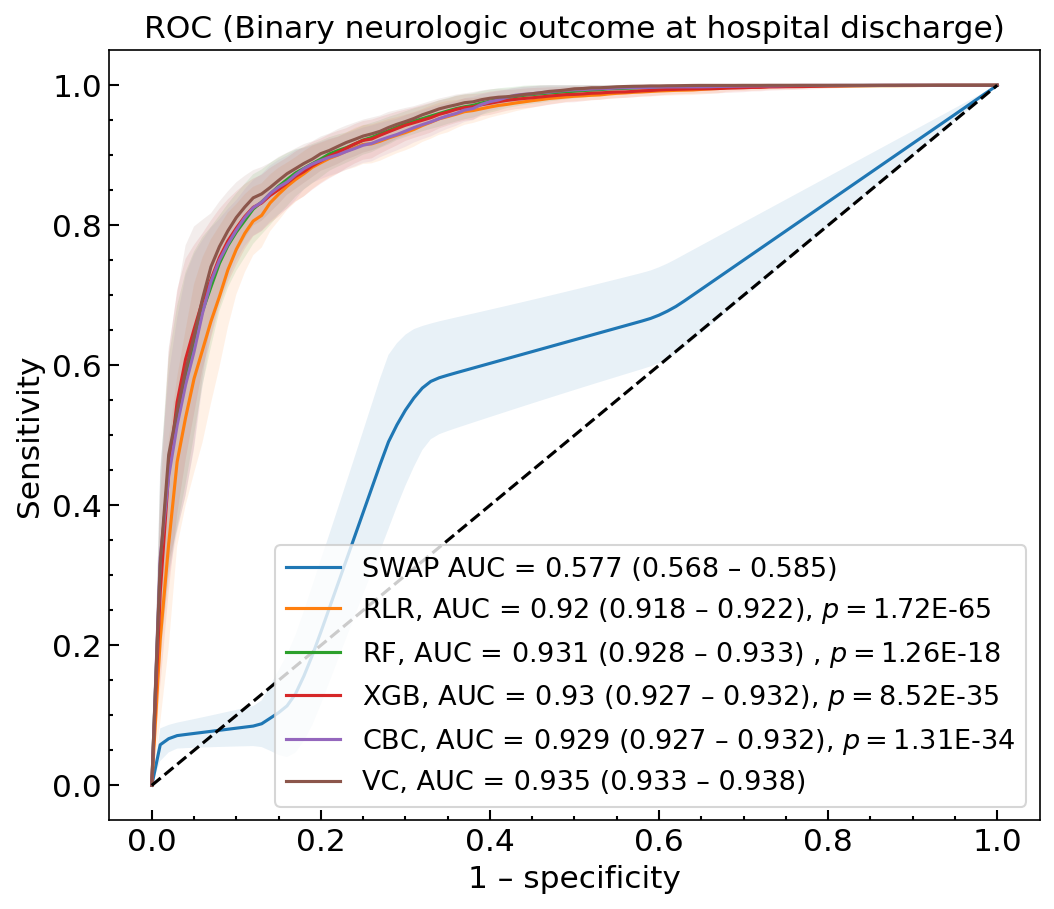

In [203]:
target = df.columns[0]

fig = plt.figure(figsize=(8.0, 6.8))    
ax = fig.add_subplot(1, 1, 1) 

#base_fpr = np.linspace(0, 1, 101)

tpr_more = interp(base_fpr, fpr, tpr)

SWAP_tprs = np.array(swap_tpr_mores)
SWAP_mean_tprs = SWAP_tprs.mean(axis=0)
SWAP_std = SWAP_tprs.std(axis=0)
SWAP_tprs_upper = np.minimum(SWAP_mean_tprs + SWAP_std, 1)
SWAP_tprs_lower = SWAP_mean_tprs - SWAP_std
ax.plot(base_fpr, SWAP_mean_tprs, label = 'SWAP AUC = {}'.format(mean_confidence_interval(swap_aucs)))
ax.fill_between(base_fpr, SWAP_tprs_lower, SWAP_tprs_upper, alpha=0.1)

# LogisticRegressionClassfier
LR_tprs = np.array(rlr_tpr_mores)
LR_aucs = np.array(rlr_aucs)
LR_mean_tprs = LR_tprs.mean(axis=0)
LR_std = LR_tprs.std(axis=0)
LR_tprs_upper = np.minimum(LR_mean_tprs + LR_std, 1)
LR_tprs_lower = LR_mean_tprs - LR_std


# RandomForestClassifier
RF_tprs = np.array(rf_tpr_mores)
RF_aucs = np.array(rf_aucs)
RF_mean_tprs = RF_tprs.mean(axis=0)
RF_std = RF_tprs.std(axis=0)
RF_tprs_upper = np.minimum(RF_mean_tprs + RF_std, 1)
RF_tprs_lower = RF_mean_tprs - RF_std


# XGboostClassifier
XGB_tprs = np.array(xgb_tpr_mores)
XGB_aucs = np.array(xgb_aucs)
XGB_mean_tprs = XGB_tprs.mean(axis=0)
XGB_std = XGB_tprs.std(axis=0)
XGB_tprs_upper = np.minimum(XGB_mean_tprs + XGB_std, 1)
XGB_tprs_lower = XGB_mean_tprs - XGB_std


# CatboostClassifier
CBC_tprs = np.array(cbc_tpr_mores)
CBC_aucs = np.array(cbc_aucs)
CBC_mean_tprs = CBC_tprs.mean(axis=0)
CBC_std = CBC_tprs.std(axis=0)
CBC_tprs_upper = np.minimum(CBC_mean_tprs + CBC_std, 1)
CBC_tprs_lower = CBC_mean_tprs - CBC_std

# EnsembleClassifier
EN_tprs = np.array(en_tpr_mores)
EN_aucs = np.array(en_aucs)
EN_mean_tprs = EN_tprs.mean(axis=0)
EN_std = EN_tprs.std(axis=0)
EN_tprs_upper = np.minimum(EN_mean_tprs + EN_std, 1)
EN_tprs_lower = EN_mean_tprs - EN_std


# comparing VC with Lositics regression
_, pvalue1 = stats.ttest_rel(LR_aucs, EN_aucs)
pval1 = '{0:1.2E}'.format(pvalue1)
# # # comparing VC with Artificial Neural Network
# # _, pvalue2 = stats.ttest_rel(ANN_aucs, EN_aucs)
# # pval2 = '{0:1.2E}'.format(pvalue2)
# # comparing VC with RandomForest
_, pvalue2 = stats.ttest_rel(RF_aucs, EN_aucs)
pval2 = '{0:1.2E}'.format(pvalue2)
# # comparing VC with XGB
_, pvalue3 = stats.ttest_rel(XGB_aucs, EN_aucs)
pval3 = '{0:1.2E}'.format(pvalue3)
_, pvalue4 = stats.ttest_rel(CBC_aucs, EN_aucs)
pval4 = '{0:1.2E}'.format(pvalue4)

# plots
ax.plot(base_fpr, LR_mean_tprs, 
        label = 'RLR, AUC = {}{}'.format(mean_confidence_interval(LR_aucs), ', $\mathit{p}=$'+str(pval1)))
#         label = 'RLR, AUC = {}, {}'.format(mean_confidence_interval(LR_aucs), '$\mathit{p}$ < 0.001'))
ax.fill_between(base_fpr, LR_tprs_lower, LR_tprs_upper, alpha=0.1)

# # ax.plot(base_fpr, ANN_mean_tprs, 
# #         label = 'ANN, AUC = {}, p{}'.format(mean_confidence_interval(ANN_aucs), '<0.001'))
# # ax.fill_between(base_fpr, ANN_tprs_lower, ANN_tprs_upper, alpha=0.1)

ax.plot(base_fpr, RF_mean_tprs, 
        label = 'RF, AUC = {} {}'.format(mean_confidence_interval(RF_aucs),', $\mathit{p}=$'+str(pval2)))
        #label = 'RF, AUC = {}, {}'.format(mean_confidence_interval(RF_aucs), '$\mathit{p}$ < 0.001'))
ax.fill_between(base_fpr, RF_tprs_lower, RF_tprs_upper, alpha=0.1)

ax.plot(base_fpr, XGB_mean_tprs, 
        label = 'XGB, AUC = {}{}'.format(mean_confidence_interval(XGB_aucs),', $\mathit{p}=$'+str(pval3)))
        #label = 'XGB, AUC = {}, {}'.format(mean_confidence_interval(XGB_aucs), '$\mathit{p}$ = 0.018'))
        #label = 'XGB, AUC = {}'.format(mean_confidence_interval(XGB_aucs)))
ax.fill_between(base_fpr, XGB_tprs_lower, XGB_tprs_upper, alpha=0.1)

ax.plot(base_fpr, CBC_mean_tprs, 
        label = 'CBC, AUC = {}{}'.format(mean_confidence_interval(CBC_aucs),', $\mathit{p}=$'+str(pval4)))
        #label = 'CBC, AUC = {}, {}'.format(mean_confidence_interval(CBC_aucs), '$\mathit{p}$ = 0.018'))
        #label = 'XGB, AUC = {}'.format(mean_confidence_interval(XGB_aucs)))
ax.fill_between(base_fpr, CBC_tprs_lower, CBC_tprs_upper, alpha=0.1)

ax.plot(base_fpr, EN_mean_tprs, 
        label = 'VC, AUC = {}'.format(mean_confidence_interval(EN_aucs)))
ax.fill_between(base_fpr, EN_tprs_lower, EN_tprs_upper, alpha=0.1)

ax.plot([0, 1], [0, 1], 'k--')    
ax.set_ylabel("Sensitivity", fontsize=15)
ax.set_xlabel("1 – specificity", fontsize=15)
ax.legend(loc='best', fontsize=13)
ax.set_title("ROC (Binary neurologic outcome at hospital discharge)", fontsize=15)
ax.minorticks_on()
ax.tick_params(which='major', length=5, width=1, direction='in')
ax.tick_params(which='minor', length=2, width=1, direction='in')
ax.tick_params(labelsize = 15)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
ax.grid(False)
png1 = BytesIO()
plt.savefig(png1, dpi=600, format='png')

# load this image into PIL
png2 = Image.open(png1)
#save as TIFF
png2.save('Figures/figure1.tif')
png1.close()
png2.close()
plt.savefig("Figures/figure1")
plt.show()

##### Sensitivity, Specificity, PPV and NPV as a function of thresholds

In [ ]:
models_perfs = []
# regularized logistic regression 

models_clfs = [rlr_clfs, rf_clfs, xgb_clfs, cbc_clfs, en_clfs]
modelnames = ["RLR", "RF", "XGB", "CBC", "VC"]
for j, model_clfs in enumerate(models_clfs) :
    sens = []
    specs = []
    ppvs = []
    npvs = []
    for th in np.arange(0.01, 1, 0.01) :
        total = np.zeros((2,2))
        for i, clf in enumerate(model_clfs) :
            ipred = clf.predict_proba(XTests[i])
            ypred = adjusted_classes(ipred[:,1], th)
            #print(confusion_matrix(yTests[i], ypred))
            total = total + confusion_matrix(yTests[i], ypred)
        conf_mtx = pd.DataFrame(total/(i+1), columns=['pred-', 'pred+'], index=['obs-', 'obs+'])
        sens.append(conf_mtx.iloc[1,1] / (conf_mtx.iloc[1,0] + conf_mtx.iloc[1,1]))
        specs.append(conf_mtx.iloc[0,0] / (conf_mtx.iloc[0,0] + conf_mtx.iloc[0,1]))
        ppvs.append(conf_mtx.iloc[1,1] / (conf_mtx.iloc[0,1] + conf_mtx.iloc[1,1]))
        npvs.append(conf_mtx.iloc[0,0] / (conf_mtx.iloc[0,0] + conf_mtx.iloc[1,0]))
    models_perfs.append([sens, specs, ppvs, npvs])

    thrs = np.arange(0.01, 1, 0.01)
    sen_arr = np.asarray(sens)
    spec_arr = np.asarray(specs)
    print(modelnames[j], np.max(sen_arr+spec_arr), thrs[np.argmax(sen_arr+spec_arr)])

In [ ]:
for swaptest in swapTest :
    print(np.unique(swaptest))

In [ ]:
fig, ax = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(8, 11.5))
thrs = np.arange(0.01, 1, 0.01).tolist()
model_seqs = ['a. ', 'b. ', 'c. ', 'd. ', 'e.']
minor_ticks = np.arange(0, 1, 0.1)
for i, model_perfs in enumerate(models_perfs) :
    r = int(i / 2)
    c = int(i % 2)
    ax[r,c].plot(thrs, model_perfs[0], label="Sensitivity")
    ax[r,c].plot(thrs, model_perfs[1], label="Specificity")
    ax[r,c].plot(thrs, model_perfs[2],label="Positive Predictive Value")
    ax[r,c].plot(thrs, model_perfs[3], label="Negative Predictive Value")
    if i == 0 :
        ax[r,c].legend(loc='lower left', bbox_to_anchor=(0.1, 0.1), 
                       columnspacing=1, labelspacing=0.1, fontsize=11)
    
    ax[r,c].tick_params(axis='both', which='both', direction='in', labelsize = 10)
    ax[r,c].tick_params(which='minor', length=2)
    ax[r,c].tick_params(which='major', length=4)
    ax[r,c].set_xticks(minor_ticks, minor=True)
    ax[r,c].set_yticks(minor_ticks, minor=True)
    if r == 1 :
        ax[r,c].set_xlabel("Threshold", fontsize=12)
    if c == 0 :
        ax[r,c].set_ylabel("Performance ", fontsize=12)
    ax[r,c].set_title(model_seqs[i]+ modelnames[i], loc='left', fontsize=12)
    
plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.15)
png1 = BytesIO()
plt.savefig(png1, format='png')

# load this image into PIL
png2 = Image.open(png1)
#save as TIFF
png2.save('Figures/figureS3.tif')
png1.close()
png2.close()
plt.savefig("Figures/figureS3")
plt.show()

In [40]:
def find_all_keys(dict1, fclass) :
    founds = []
    for k, v in dict1.items() :
        if v == fclass :
            founds.append(k)
    return founds

### Presenting models' metrics 

In [41]:
def performance_model(cm) :
    
    recall = cm.iloc[1,1] / (cm.iloc[1,0] + cm.iloc[1,1]) 
    precision = cm.iloc[0,0] / (cm.iloc[0,0] + cm.iloc[0,1])
    ppv = cm.iloc[1,1] / (cm.iloc[0,1] + cm.iloc[1,1])
    npv = cm.iloc[0,0] / (cm.iloc[0,0] + cm.iloc[1,0])
    fmeasure = 2 * (precision * recall) / (precision + recall)
    return [recall, precision, ppv, npv, fmeasure]


def nri_models(predA_done, predB_done, TRue) :
    # test : predA_done
    # control : predB_done
    # true : TRue
    dictA = dict(enumerate(predA_done))
    dictB = dict(enumerate(predB_done))
    dictT = dict(enumerate(TRue))
    if len(dictA) == len(dictB) and len(dictB) == len(dictT) :
        # Event
        setA = set(find_all_keys(dictA, 1))
        setB = set(find_all_keys(dictB, 1))
        setT = set(find_all_keys(dictT, 1))
        setAT = setA & setT
        setBT = setB & setT
        nri_event = (len(setAT - setBT) - len(setBT - setAT)) / len(setT)
        # Non-event
        setA = set(find_all_keys(dictA, 0))
        setB = set(find_all_keys(dictB, 0))
        setT = set(find_all_keys(dictT, 0))
        setAT = setA & setT
        setBT = setB & setT
        nri_nonevent = (len(setAT - setBT) - len(setBT - setAT)) / len(setT)
        return nri_event + nri_nonevent 
    else :
        return np.nan

In [51]:
# Sensitivity, Specificity, Positive Predictive Value, Negative Predictive Value, F-measure, NRI
perform1 = [] # rlr
perform2 = [] # rf
perform3 = [] # xgb
perform4 = [] # cbc
perform5 = [] # en
perform6 = [] # swap

for i, (clf1, clf2, clf3, clf4, clf5) in enumerate(zip(rlr_clfs, rf_clfs, xgb_clfs, cbc_clfs, en_clfs)) :
    # rlr
    pred1 = clf1.predict_proba(XTests[i])
    pred1_done = adjusted_classes(pred1[:,1], rlr_thr_opts[i])
    cm1 = pd.DataFrame(confusion_matrix(yTests[i], pred1_done))
    if i == 0:
        cm_rlr = cm1
    else :
        cm_rlr = cm_rlr+cm1
    kappa = cohen_kappa_score(yTests[i], pred1_done, labels=None, weights=None)
    _perform1 = performance_model(cm1)
    _perform1.append(kappa)
    
    # rf
    pred2 = clf2.predict_proba(XTests[i])
    pred2_done = adjusted_classes(pred2[:,1], rf_thr_opts[i])
    cm2 = pd.DataFrame(confusion_matrix(yTests[i], pred2_done))
    if i == 0:
        cm_rf = cm2
    else :
        cm_rf = cm_rf+cm2
    kappa = cohen_kappa_score(yTests[i], pred2_done, labels=None, weights=None)
    _perform2 = performance_model(cm2)
    _perform2.append(kappa)
    
    # xgb
    pred3 = clf3.predict_proba(XTests[i])
    pred3_done = adjusted_classes(pred3[:,1], xgb_thr_opts[i])
    cm3 = pd.DataFrame(confusion_matrix(yTests[i], pred3_done))
    if i == 0:
        cm_xgb = cm3
    else :
        cm_xgb = cm_xgb+cm3
    kappa = cohen_kappa_score(yTests[i], pred3_done, labels=None, weights=None)
    _perform3 = performance_model(cm3)
    _perform3.append(kappa)
    
    # cbc
    pred4 = clf4.predict_proba(XTests[i])
    pred4_done = adjusted_classes(pred4[:,1], cbc_thr_opts[i])
    cm4 = pd.DataFrame(confusion_matrix(yTests[i], pred4_done))
    if i == 0:
        cm_cbc = cm4
    else :
        cm_cbc = cm_cbc+cm4
    kappa = cohen_kappa_score(yTests[i], pred4_done, labels=None, weights=None)
    _perform4 = performance_model(cm4)
    _perform4.append(kappa)
    
    # en
    ipred = clf5.predict_proba(XTests[i])
    pred5_done = adjusted_classes(ipred[:,1], en_thr_opts[i])
    cm5 = pd.DataFrame(confusion_matrix(yTests[i], pred5_done))
    if i == 0:
        cm_vc = cm5
    else :
        cm_vc = cm_vc+cm5
    kappa = cohen_kappa_score(yTests[i], pred5_done, labels=None, weights=None)
    _perform5 = performance_model(cm5)
    _perform5.append(kappa)
    
    
    # SWAP Score
    swap_test = swapTest[i]
    swap_test = 4 - swap_test
    pred6_done = adjusted_classes(swap_test, swap_thr_opts[i])
    cm6 = pd.DataFrame(confusion_matrix(yTests[i], pred6_done))
    if i == 0:
        cm_swap = cm6
    else :
        cm_swap = cm_swap+cm6
    kappa = cohen_kappa_score(yTests[i], pred6_done, labels=None, weights=None)
    _perform6 = performance_model(cm6)
    _perform6.append(kappa)
    
    # NRI
    _perform2.append(nri_models(pred2_done, pred1_done, yTests[i]))
    _perform3.append(nri_models(pred3_done, pred1_done, yTests[i]))
    _perform4.append(nri_models(pred4_done, pred1_done, yTests[i]))
    _perform5.append(nri_models(pred5_done, pred1_done, yTests[i]))
    _perform6.append(nri_models(pred6_done, pred1_done, yTests[i]))
    
    perform1.append(np.array(_perform1))
    perform2.append(np.array(_perform2))
    perform3.append(np.array(_perform3))
    perform4.append(np.array(_perform4))
    perform5.append(np.array(_perform5))
    perform6.append(np.array(_perform6))
    
mat1 = np.array(perform1).transpose()
mat2 = np.array(perform2).transpose()
mat3 = np.array(perform3).transpose()
mat4 = np.array(perform4).transpose()
mat5 = np.array(perform5).transpose()
mat6 = np.array(perform6).transpose()


try :
    rlr_ppv = mean_confidence_interval(mat1[2])
except ValueError:
    rlr_ppv = "n.a."
    
df_perf = pd.DataFrame(columns = ['Metrics', 'SWAP_Score', 'RLR', 'RF', 'XGB', 'CBC', 'VC'])
                      
Metrics = ['Sensitivity', 'Specificity', 'PPV', 'NPV', 'F1-score', 'Kappa', 'NRI']
for j in range(7) :
    if j == 6 :
        df_perf.loc[len(df_perf)] = [Metrics[j], np.nan,
                                    mean_confidence_interval(mat6[j], lb=" "),
                                    mean_confidence_interval(mat2[j], lb=" "),
                                    mean_confidence_interval(mat3[j], lb=" "),
                                    mean_confidence_interval(mat4[j], lb=" "),
                                    mean_confidence_interval(mat5[j], lb=" ") 
                                    ]
    else :
        df_perf.loc[len(df_perf)] = [Metrics[j],
                                    mean_confidence_interval(mat6[j], lb=" "),
                                    mean_confidence_interval(mat1[j], lb=" "),
                                    mean_confidence_interval(mat2[j], lb=" "),
                                    mean_confidence_interval(mat3[j], lb=" "),
                                    mean_confidence_interval(mat4[j], lb=" "),
                                    mean_confidence_interval(mat5[j], lb=" ") 
                                    ]
    
df_perf.set_index('Metrics').to_csv("metrics.csv")

In [52]:
df_perf

,Metrics,SWAP_Score,RLR,RF,XGB,CBC,VC
0,Sensitivity,0.571 (0.559 – 0.584),0.867 (0.862 – 0.872),0.876 (0.869 – 0.882),0.861 (0.853 – 0.868),0.867 (0.861 – 0.872),0.87 (0.865 – 0.876)
1,Specificity,0.695 (0.691 – 0.698),0.855 (0.849 – 0.861),0.856 (0.849 – 0.862),0.874 (0.865 – 0.882),0.862 (0.856 – 0.867),0.874 (0.867 – 0.881)
2,PPV,0.436 (0.428 – 0.443),0.717 (0.709 – 0.725),0.721 (0.712 – 0.729),0.747 (0.736 – 0.759),0.726 (0.718 – 0.734),0.747 (0.737 – 0.757)
3,NPV,0.797 (0.792 – 0.802),0.94 (0.938 – 0.942),0.944 (0.941 – 0.946),0.939 (0.936 – 0.942),0.94 (0.938 – 0.942),0.942 (0.94 – 0.945)
4,F1-score,0.625 (0.616 – 0.633),0.86 (0.857 – 0.863),0.864 (0.861 – 0.867),0.865 (0.861 – 0.868),0.863 (0.861 – 0.866),0.871 (0.868 – 0.874)
5,Kappa,0.243 (0.23 – 0.257),0.68 (0.673 – 0.687),0.688 (0.68 – 0.695),0.702 (0.693 – 0.711),0.689 (0.682 – 0.696),0.71 (0.701 – 0.718)
6,NRI,NaN,-0.456 (-0.473 – -0.439),0.00948 (0.00568 – 0.013),0.0121 (0.00805 – 0.016),0.00658 (0.00316 – 0.010),0.0224 (0.0192 – 0.026)


In [53]:
(cm_rlr / (i+1)).to_csv("rlr_cm.csv")
(cm_rf / (i+1)).to_csv("rf_cm.csv")
(cm_xgb / (i+1)).to_csv("xgb_cm.csv")
(cm_cbc / (i+1)).to_csv("cbc_cm.csv")
(cm_vc / (i+1)).to_csv("vc_cm.csv")
(cm_swap / (i+1)).to_csv("swap_cm.csv")

In [47]:
def ptable_to_csv(table, filename, headers=True):
    """Save PrettyTable results to a CSV file.

    Adapted from @AdamSmith https://stackoverflow.com/questions/32128226

    :param PrettyTable table: Table object to get data from.
    :param str filename: Filepath for the output CSV.
    :param bool headers: Whether to include the header row in the CSV.
    :return: None
    """
    raw = table.get_string()
    data = [tuple(filter(None, map(str.strip, splitline)))
            for line in raw.splitlines()
            for splitline in [line.split('|')] if len(splitline) > 1]
#     if table.title is not None:
#         data = data[1:]
    if not headers:
        data = data[1:]
    with open(filename, 'w') as f:
        for d in data:
            f.write('{}\n'.format(','.join(d)))

In [49]:
# ptable_to_csv(table2, "table2.csv", True)

### Table for predicted survival, AUC (95%), Brier score and Logloss

In [ ]:
print(yT.shape)
yT[yT==1].shape

In [54]:
# Sensitivity, Specificity, Positive Predictive Value, Negative Predictive Value, F-measure, NRI
prob1 = [] # rlr
prob2 = [] # rf
prob3 = [] # xgb
prob4 = [] # cbc
prob5 = [] # en
prob6 = [] # swap

df_perf2 = pd.DataFrame(columns=['Model', 'Actual', 'SWAP Score', 'RLR', 'RF', 'XGB', 'CBC', 'VC'])
yT = yTests[0]

#df_perf2.loc[len(df_perf2)] = ["Actual", , '','','']
for i, (clf1, clf2, clf3, clf4, clf5) in enumerate(zip(rlr_clfs, rf_clfs, xgb_clfs, cbc_clfs, en_clfs)) :
    # rlr
    pred1 = clf1.predict_proba(XTests[i])
    pred1_done = adjusted_classes(pred1[:,1], rlr_thr_opts[i])
    prob1.append(np.where(np.array(pred1_done)==1)[0].shape[0]/len(pred1_done))
    
#   # rf
    pred2 = clf2.predict_proba(XTests[i])
    pred2_done = adjusted_classes(pred2[:,1], rf_thr_opts[i])
    prob2.append(np.where(np.array(pred2_done)==1)[0].shape[0]/len(pred2_done))
    
#   # xgb
    pred3 = clf3.predict_proba(XTests[i])
    pred3_done = adjusted_classes(pred3[:,1], xgb_thr_opts[i])
    prob3.append(np.where(np.array(pred3_done)==1)[0].shape[0]/len(pred3_done))
    
    #cbc
    pred4 = clf4.predict_proba(XTests[i])
    pred4_done = adjusted_classes(pred4[:,1], cbc_thr_opts[i])
    prob4.append(np.where(np.array(pred4_done)==1)[0].shape[0]/len(pred4_done))
    
#   # en
    pred5 = clf5.predict_proba(XTests[i])
    pred5_done = adjusted_classes(pred5[:,1], en_thr_opts[i])
    prob5.append(np.where(np.array(pred5_done)==1)[0].shape[0]/len(pred5_done))
    
    # SWAP Score
    swap_test = swapTest[i]
    swap_test = 4 - swap_test
    pred6_done = adjusted_classes(swap_test, swap_thr_opts[i])
    prob6.append(np.where(np.array(pred6_done)==1)[0].shape[0]/len(pred6_done))
    

df_perf2.loc[len(df_perf2)] = ["Predicted", format(yT[yT==1].shape[0]/yT.shape[0], '.3f'),
                               mean_confidence_interval(prob6),
                               mean_confidence_interval(prob1), 
                               mean_confidence_interval(prob2), 
                               mean_confidence_interval(prob3),
                               mean_confidence_interval(prob4),
                               mean_confidence_interval(prob5)]

df_perf2.loc[len(df_perf2)] = ["AUC", '',
                               mean_confidence_interval(swap_aucs),
                               mean_confidence_interval(rlr_aucs),
                               mean_confidence_interval(rf_aucs),
                               mean_confidence_interval(xgb_aucs),
                               mean_confidence_interval(cbc_aucs),
                               mean_confidence_interval(en_aucs)]
                               
df_perf2.loc[len(df_perf2)] = ["Brier score", '',
                               mean_confidence_interval(swap_brier_loss),
                               mean_confidence_interval(rlr_brier_loss),
                               mean_confidence_interval(rf_brier_loss),
                               mean_confidence_interval(xgb_brier_loss),
                               mean_confidence_interval(cbc_brier_loss),
                               mean_confidence_interval(en_brier_loss)]
                  
df_perf2.loc[len(df_perf2)] = ["Log loss", '',
                               mean_confidence_interval(swap_log_loss),
                               mean_confidence_interval(rlr_log_loss),
                               mean_confidence_interval(rf_log_loss),
                               mean_confidence_interval(xgb_log_loss),
                               mean_confidence_interval(cbc_log_loss),
                               mean_confidence_interval(en_log_loss)]
df_perf2

,Model,Actual,SWAP Score,RLR,RF,XGB,CBC,VC
0,Predicted,0.294,0.383 (0.381 – 0.386),0.357 (0.351 – 0.362),0.359 (0.353 – 0.365),0.342 (0.334 – 0.349),0.352 (0.347 – 0.356),0.344 (0.338 – 0.350)
1,AUC,,0.577 (0.568 – 0.585),0.92 (0.918 – 0.922),0.931 (0.928 – 0.933),0.93 (0.927 – 0.932),0.929 (0.927 – 0.932),0.935 (0.933 – 0.938)
2,Brier score,,0.707 (0.707 – 0.707),0.111 (0.109 – 0.114),0.0972 (0.0954 – 0.099),0.113 (0.111 – 0.116),0.096 (0.0945 – 0.098),0.0927 (0.0909 – 0.095)
3,Log loss,,18.1 (18.0 – 18.200),0.368 (0.362 – 0.375),0.326 (0.316 – 0.336),0.429 (0.416 – 0.443),0.314 (0.31 – 0.319),0.3 (0.295 – 0.305)


In [55]:
df_perf2.to_csv("scores.csv", index=False)

### Feature importance of models

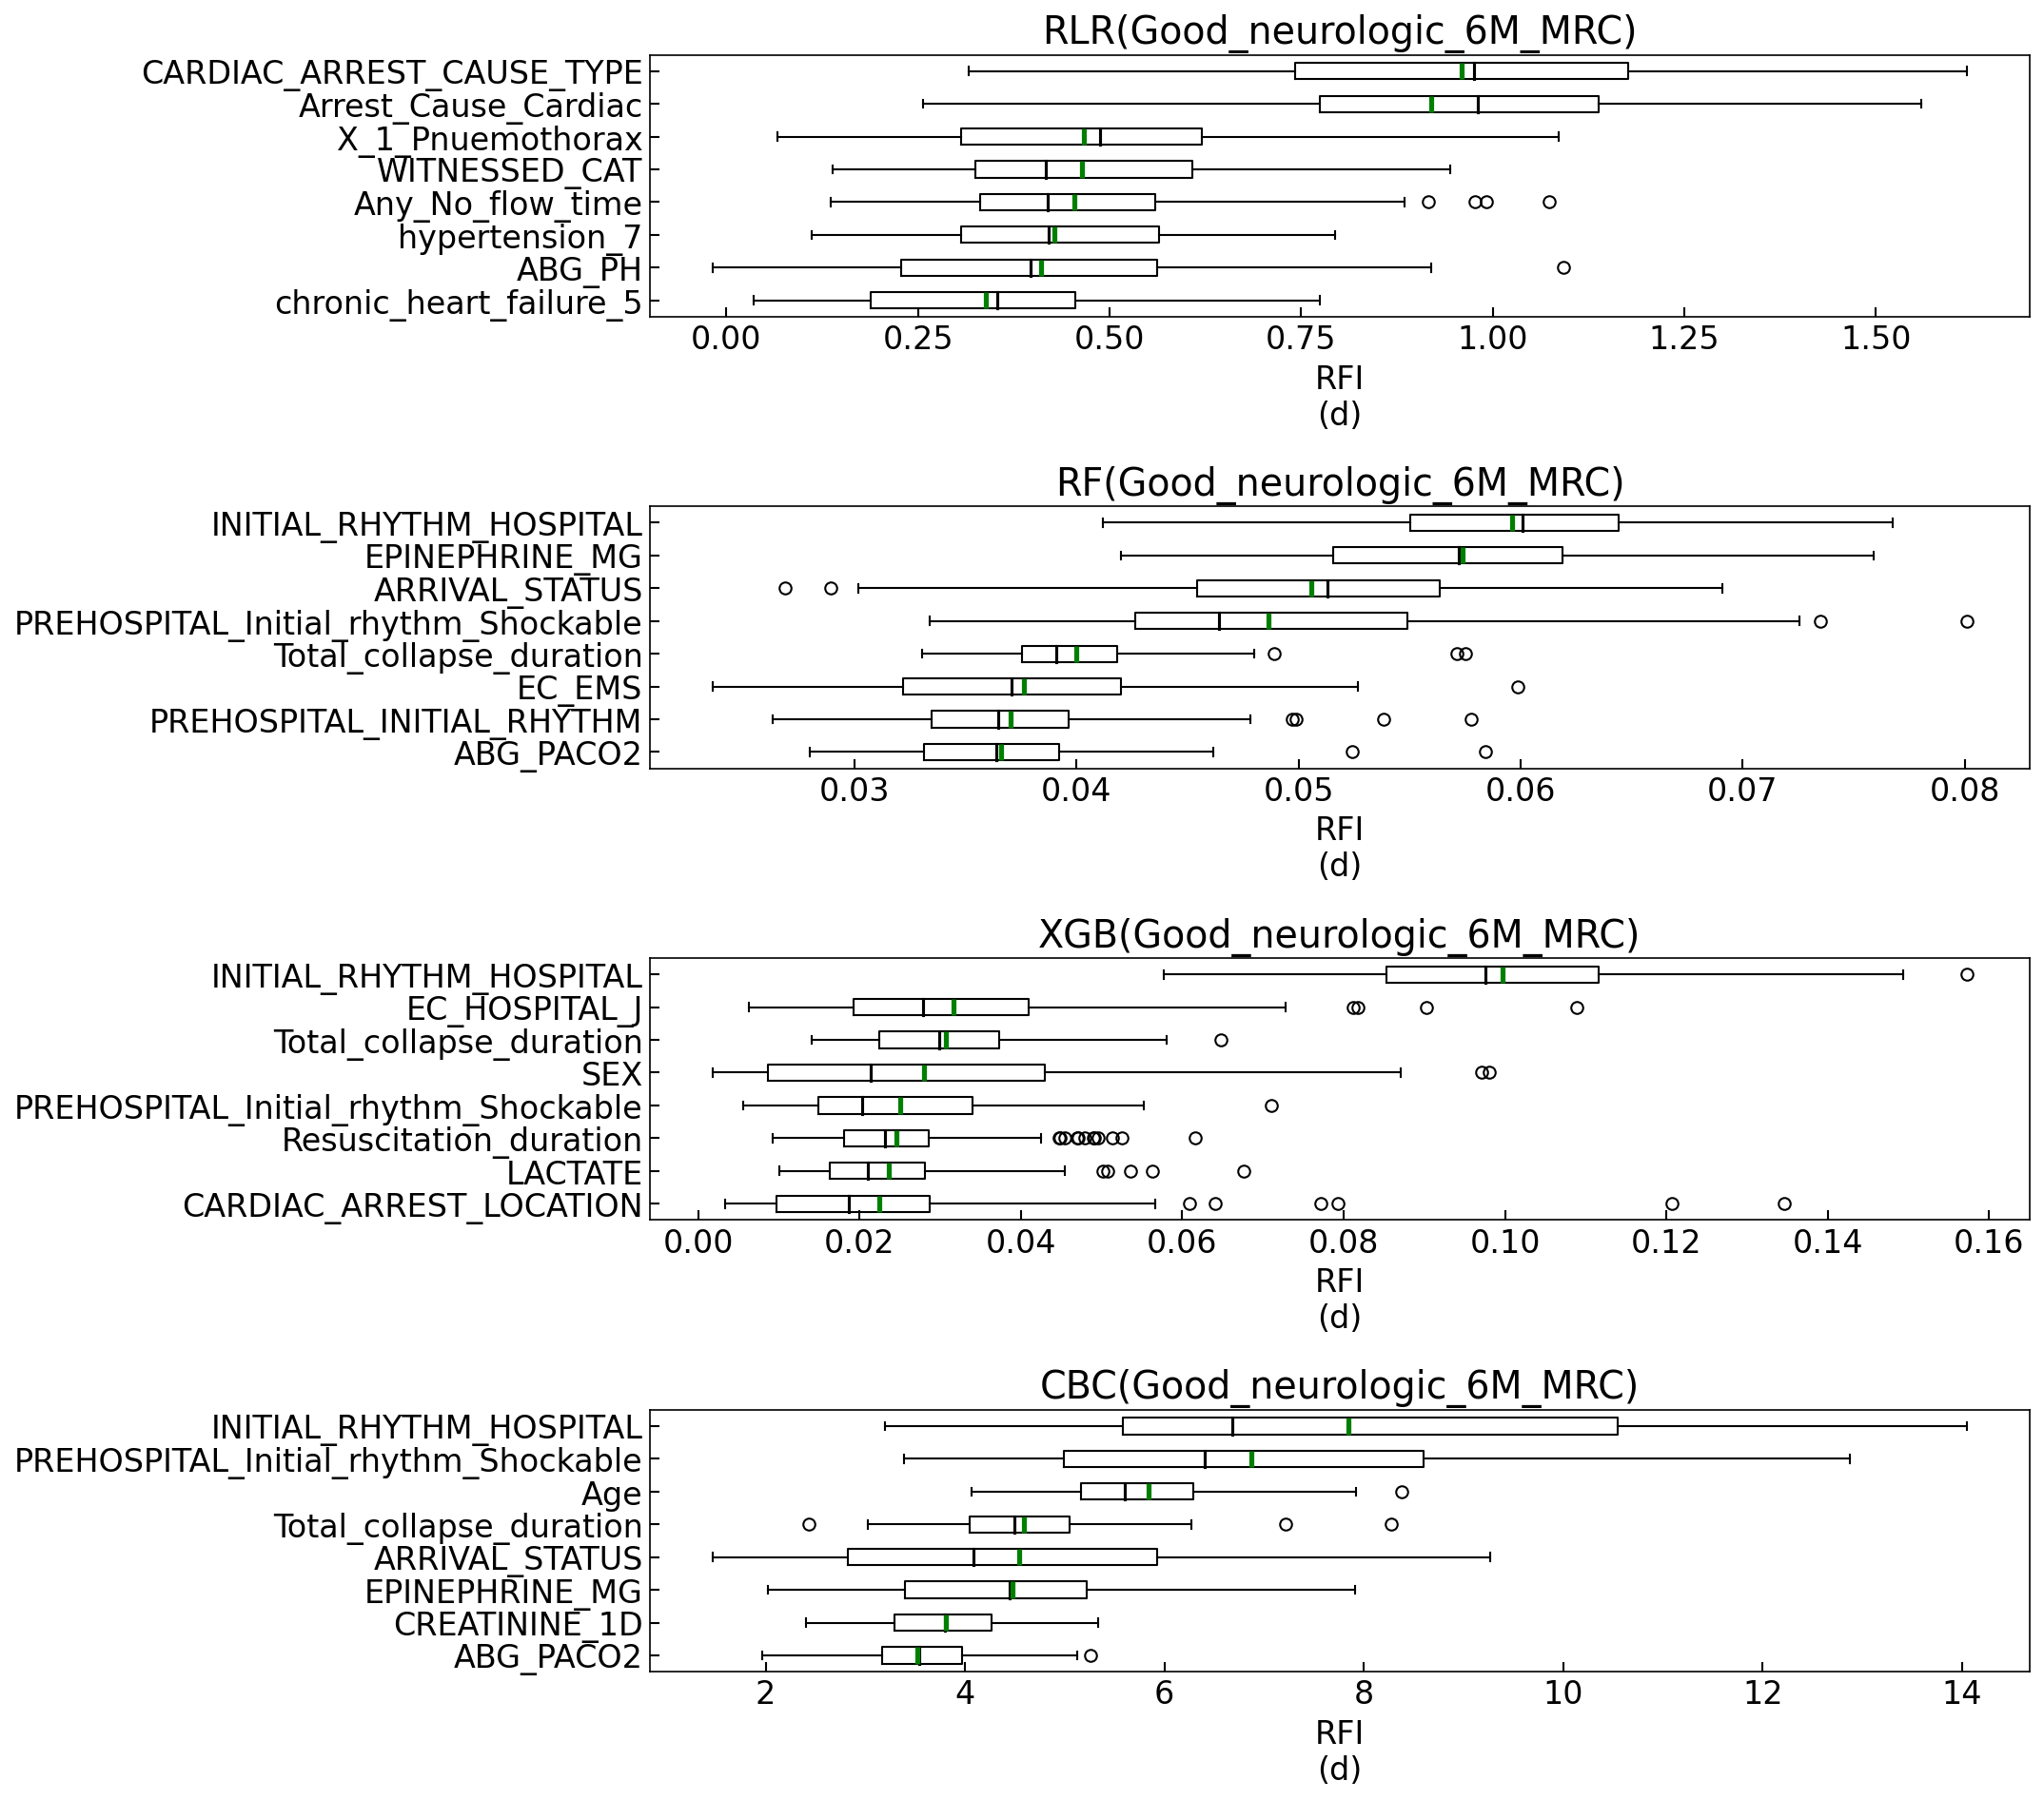

In [340]:
fig = plt.figure(figsize = (14.6, 12.9))
target = 'Good_neurologic_6M_MRC'
models = ['RLR', 'RF', 'XGB', 'CBC']
for i, imps in enumerate([rlr_imps, rf_imps, xgb_imps, cbc_imps]) :

    ax = fig.add_subplot(4, 1, i+1) 

    feat_num = 8
    names = df.loc[:,'Age':'ECPR'].columns
    imps1 = np.array(imps)
    argsort1 = np.argsort(-np.mean(imps1, axis = 0))[::-1]
    meanlineprops = dict(linestyle='--', linewidth=2.5, color='green')
    bp1 = ax.boxplot([imps1[:, x] for x in argsort1[-feat_num:]], 
                     labels = [names[x] for x in argsort1[-feat_num:]], 
                     patch_artist=False, vert=False, showmeans=True, 
                     meanline=True, meanprops=meanlineprops)

    for median in bp1['medians']:
        median.set(color='black', linewidth=1.5)

    ax.tick_params(labelsize = 16)
    ax.set_title(models[i]+"("+target+")", fontsize=19)
    ax.set_xlabel("RFI\n(d)", fontsize=16)
    ax.tick_params(axis='x')
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.grid(False)
    #ax.minorticks_on()
    ax.tick_params(which='major', length=5, width=1, direction='in')
    ax.tick_params(which='minor', length=2, width=1, direction='in', axis='y')
#ax.text(-0.04, 1.1, 'D', fontsize=17, ha='left',va='center', transform=ax.transAxes)
#plt.tight_layout()
#fig.savefig("Figures/figure3aa.png", bbox_inches = "tight")
plt.tight_layout()
png1 = BytesIO()
plt.savefig(png1, format='png', bbox_inches="tight")

# load this image into PIL
png2 = Image.open(png1)
#save as TIFF
png2.save('Figures/figure_fimp.tif')
png1.close()
png2.close()
plt.savefig("Figures/figure_fimp", bbox_inches="tight")
plt.show()

### Model Interpretation by SHAP

In [223]:
XTrain_df = pd.DataFrame(XTrain, columns=df.loc[:,'Age':'ECPR'].columns)

In [270]:
explainer = shap.Explainer(en_clfs[-1].predict_proba, XTrain_df)
shape_values = explainer(XTrain_df)

Permutation explainer: 1088it [1:27:52,  4.86s/it]                          


In [277]:
shap_values_positive = shap_values[...,1]
shap_values_negative = shap_values[...,0]

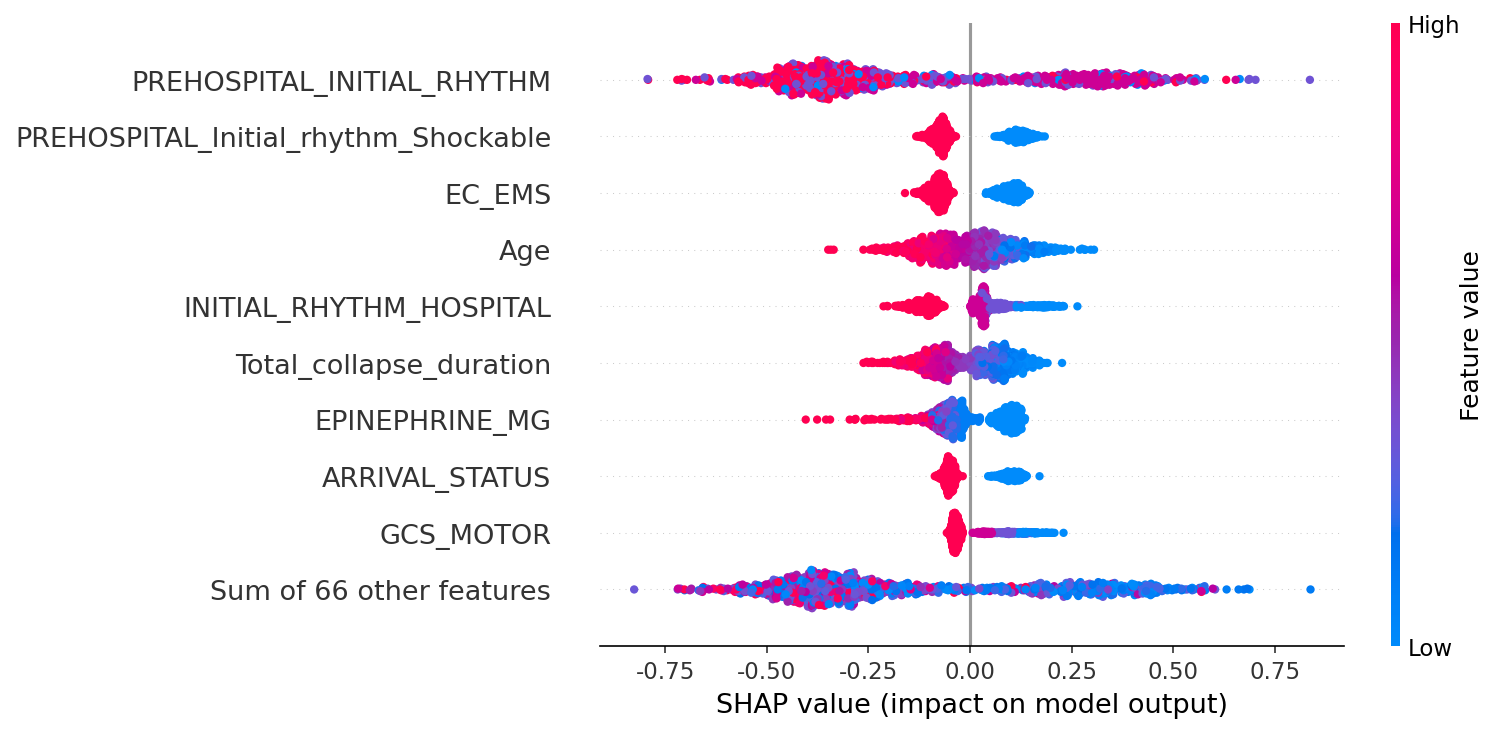

In [280]:
shap.plots.beeswarm(shap_values_positive)

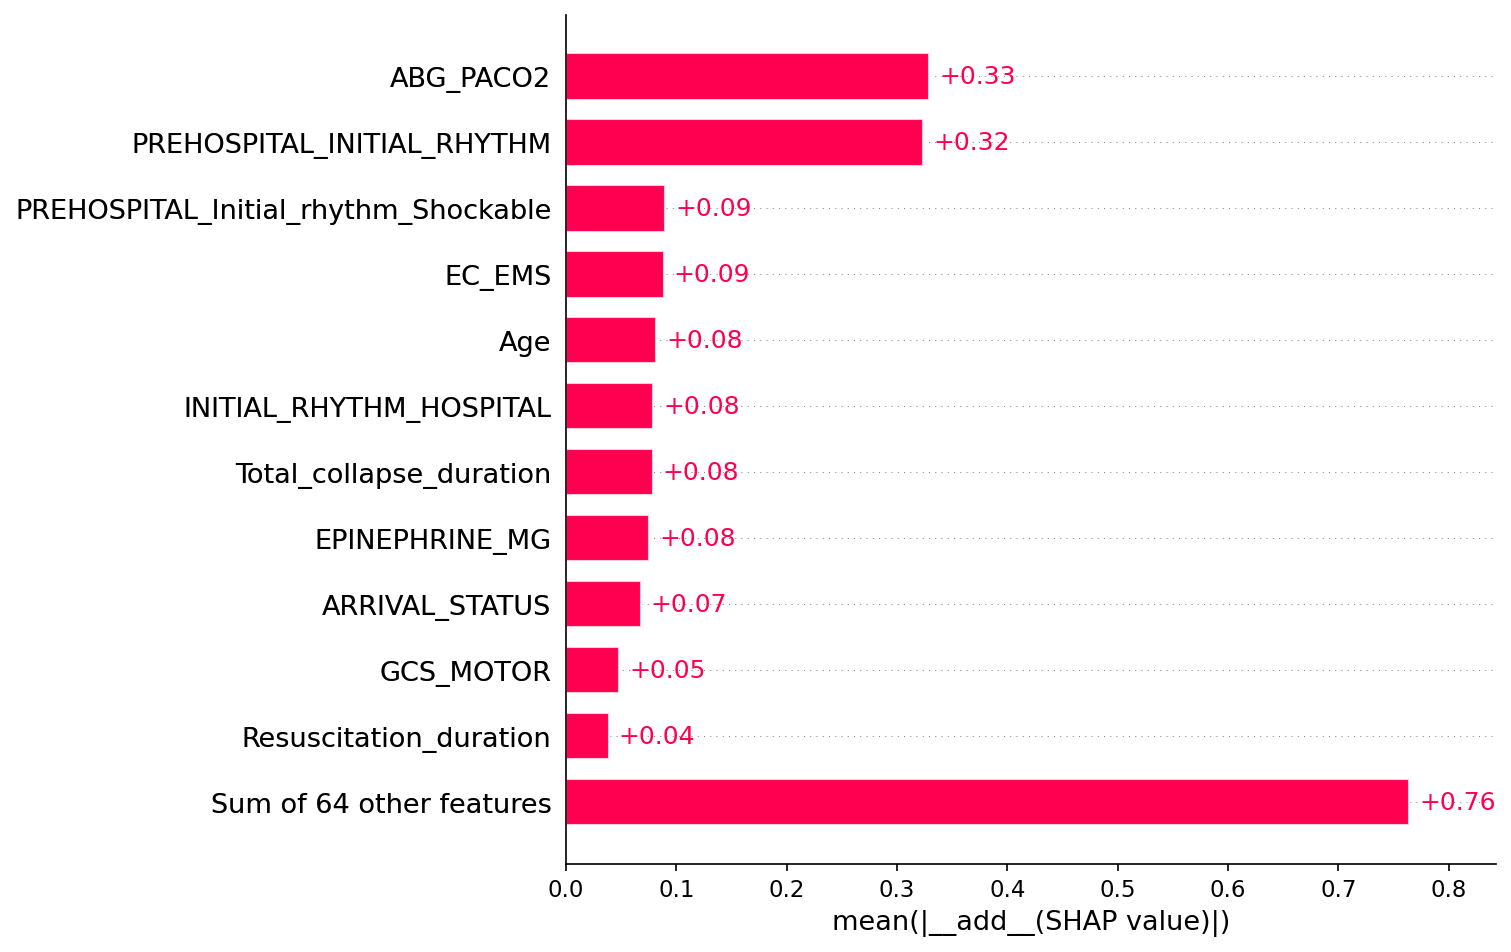

In [332]:
shap.plots.bar(shap_values_positive, max_display=12) 

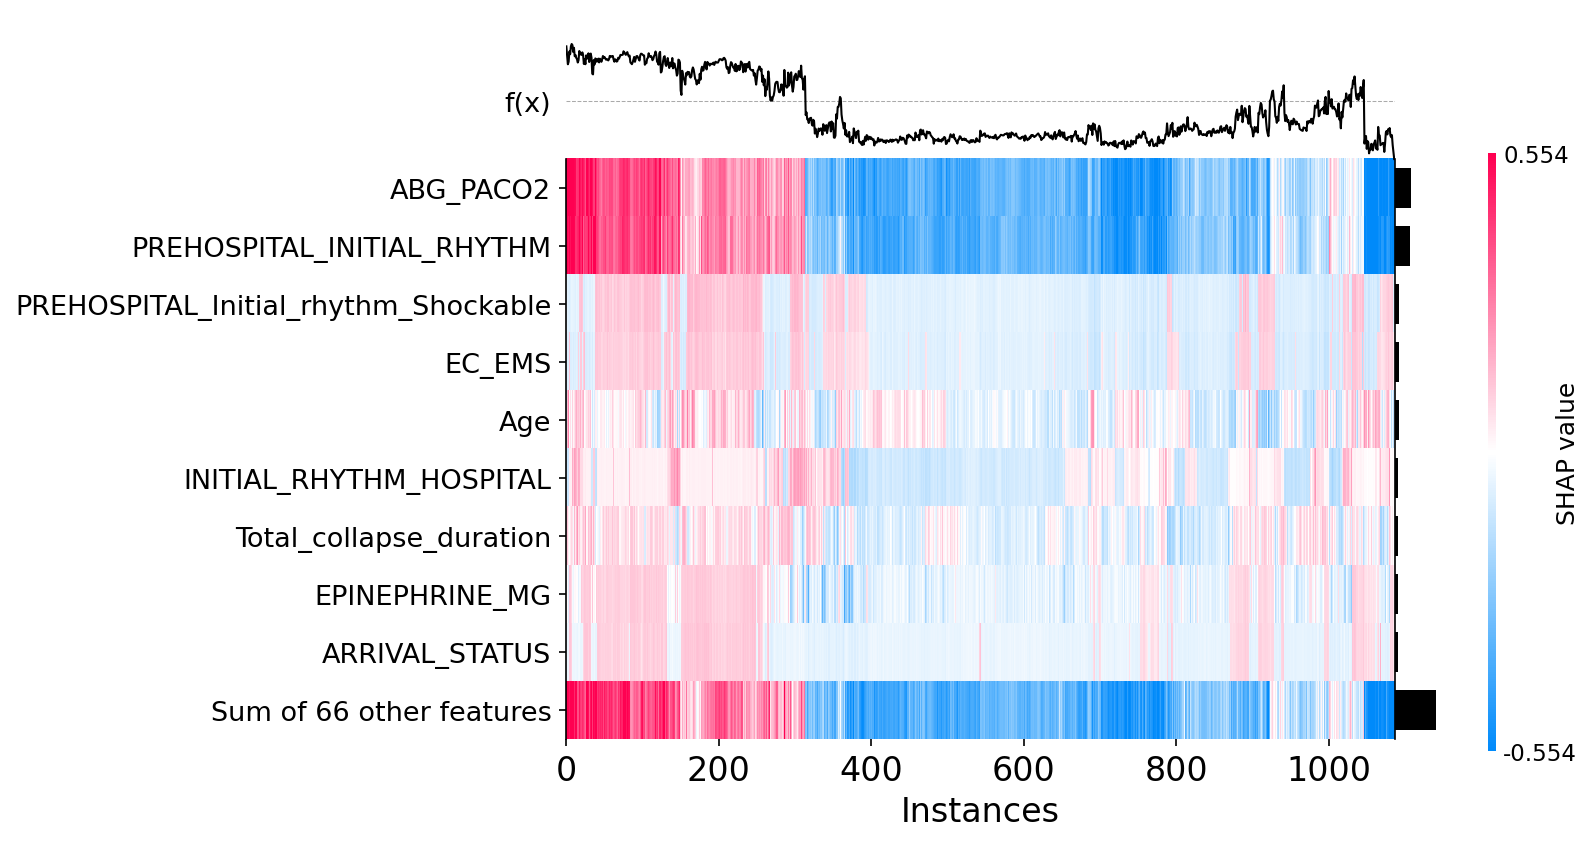

In [330]:
shap.plots.heatmap(shap_values_positive)

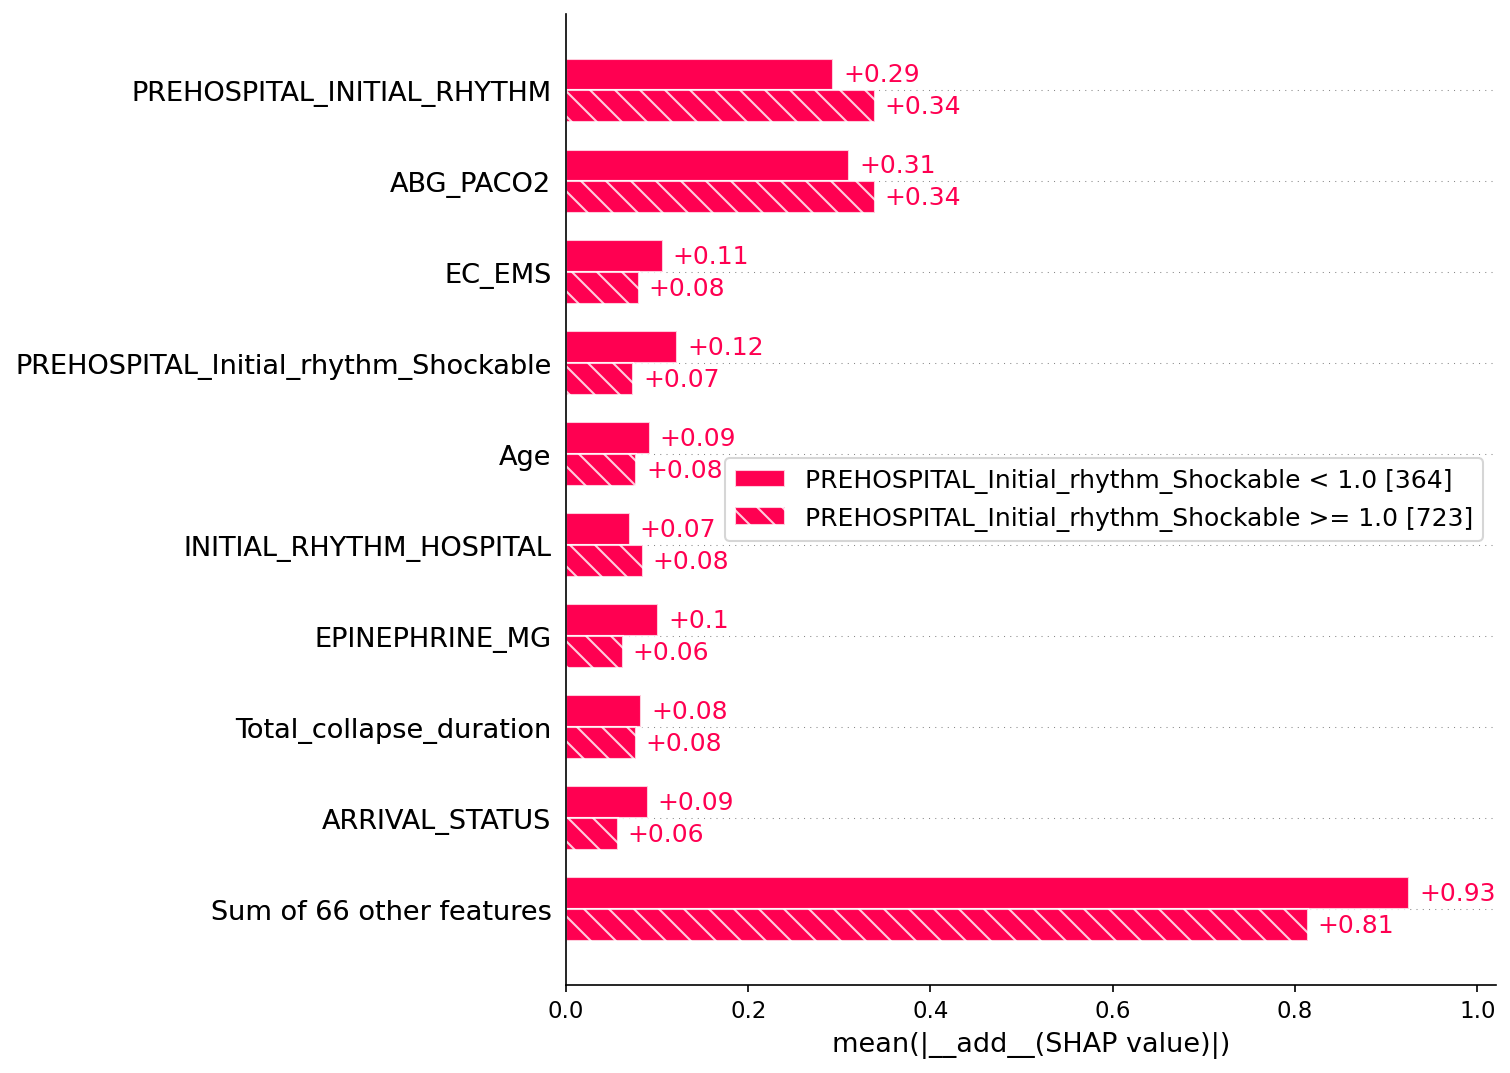

In [329]:
shap.plots.bar(shap_values_positive.cohorts(2).abs.mean(0))

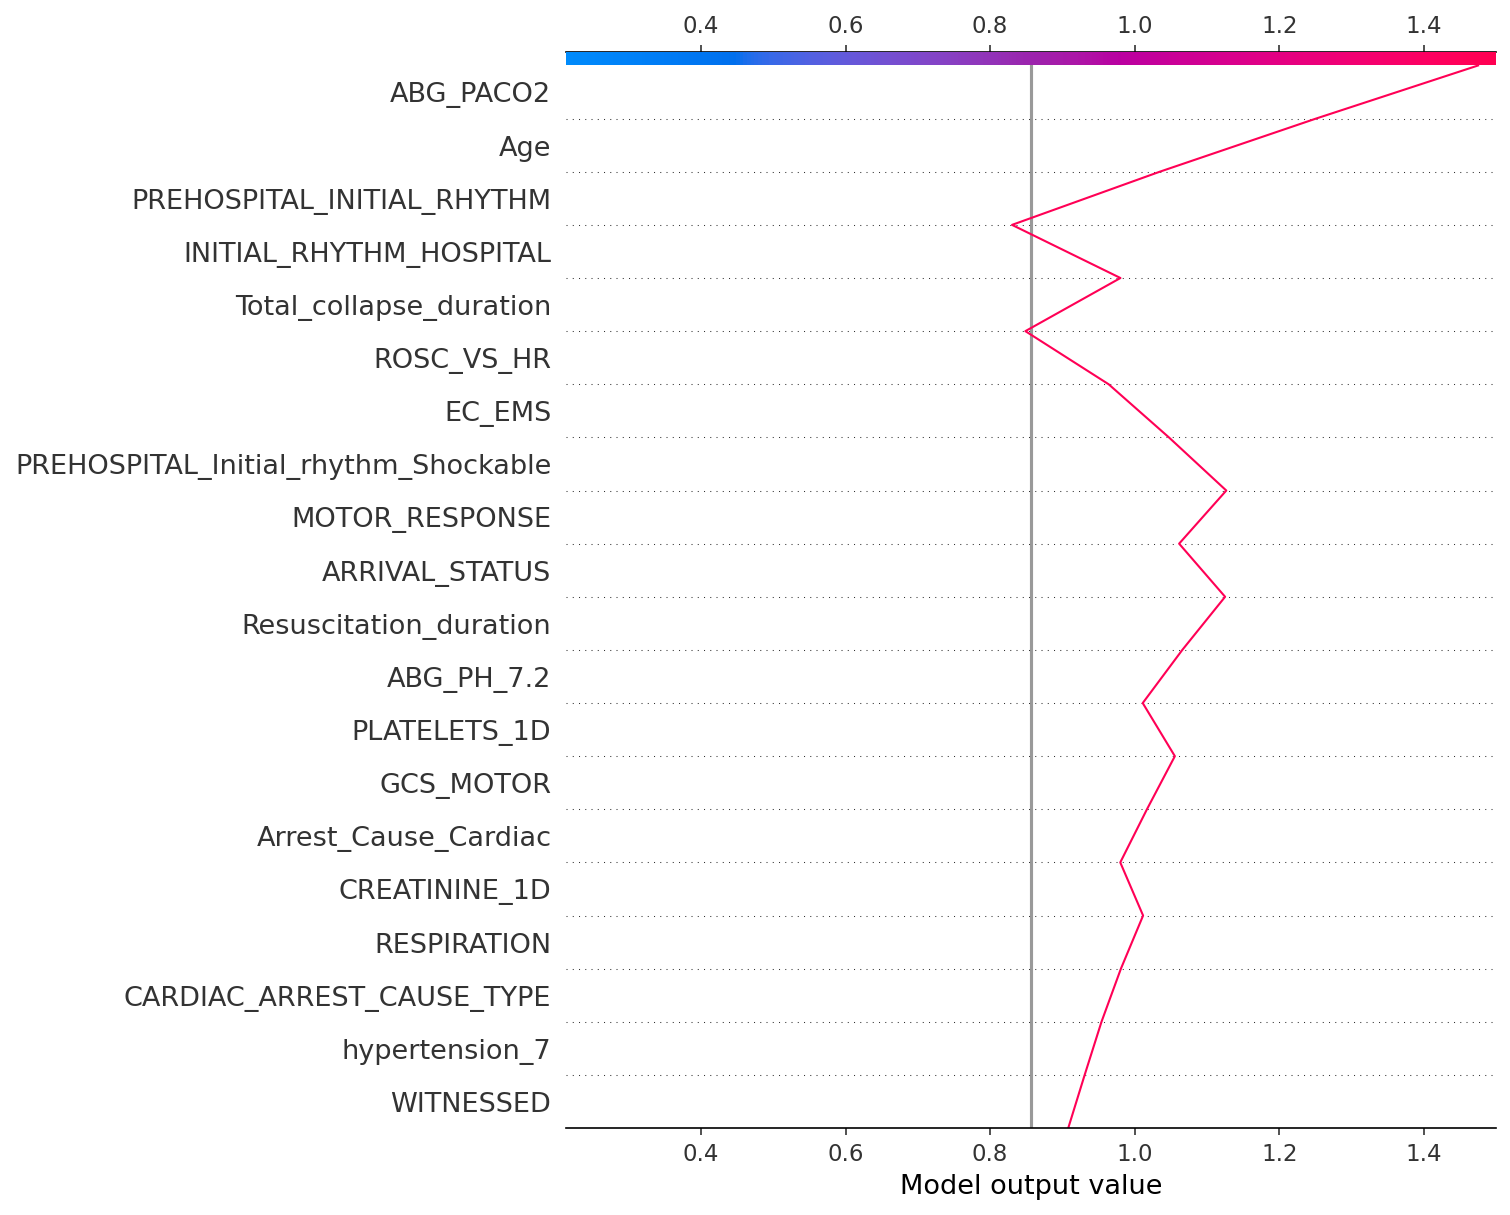

In [326]:
shap.decision_plot(shap_values_positive.base_values[0], shap_values_positive.values[0, :], 
                   feature_names=XTrain_df.columns.tolist())

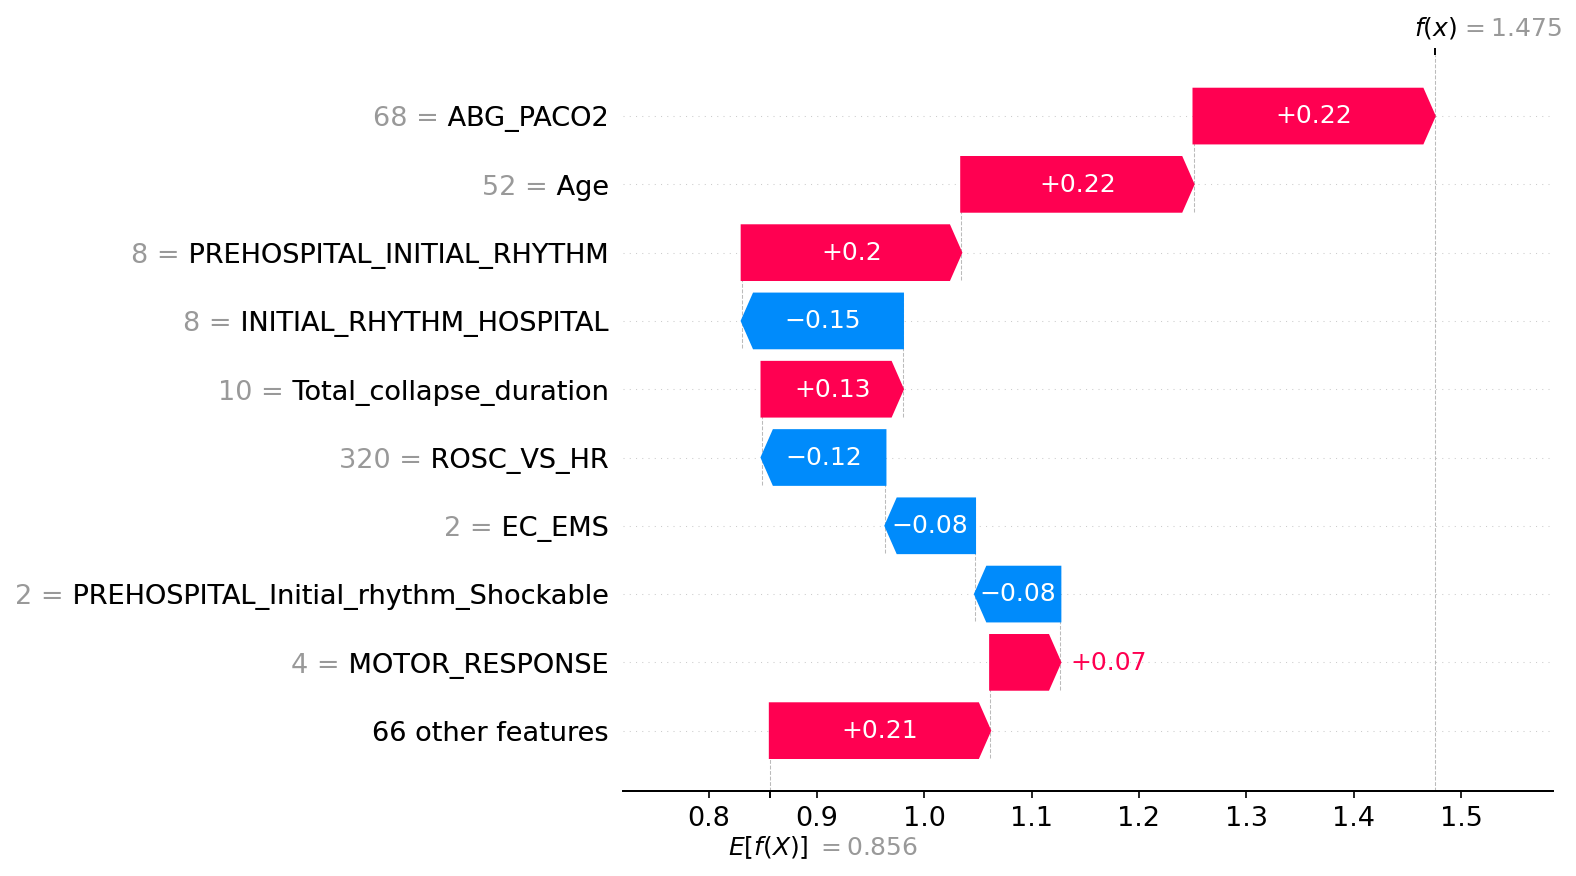

In [342]:
shap.plots.waterfall(shap_values_positive[0])

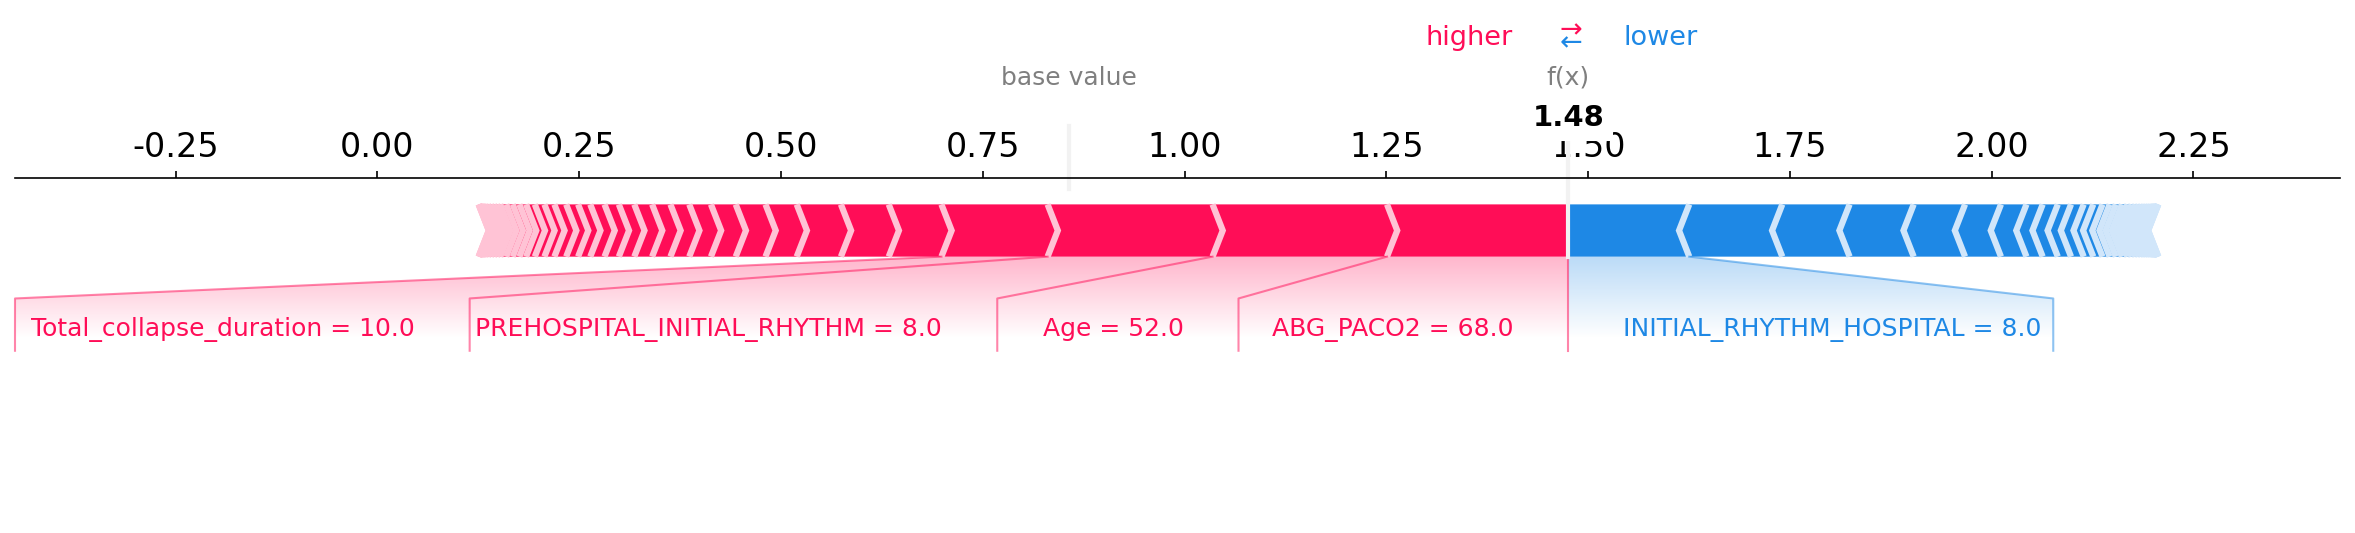

In [352]:
shap.force_plot(shap_values_positive[0], matplotlib=True)

### Test-set

In [344]:
XTest_df = pd.DataFrame(XTests[-1], columns=df.loc[:,'Age':'ECPR'].columns)

In [345]:
explainer = shap.Explainer(en_clfs[-1].predict_proba, XTest_df)
shape_values = explainer(XTest_df)

Permutation explainer: 272it [22:08,  4.94s/it]                         


In [347]:
shap_values_positive_test = shape_values[..., 1]

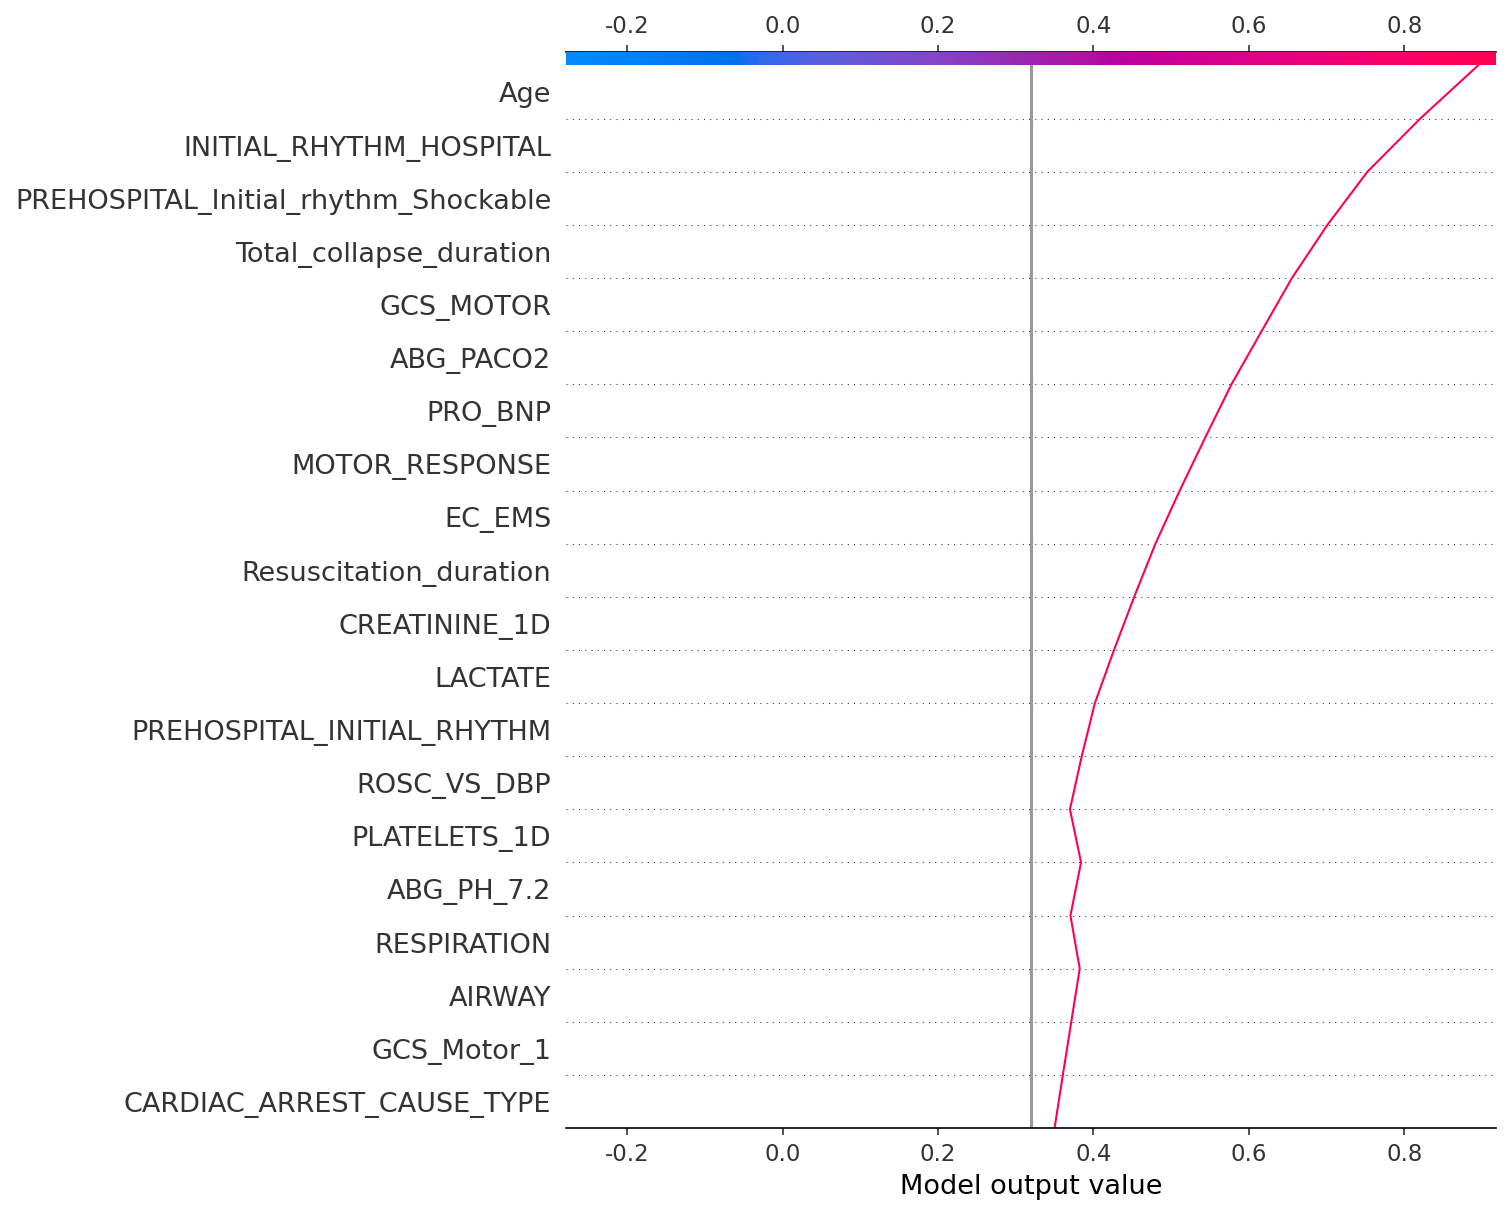

In [348]:
shap.decision_plot(shap_values_positive_test.base_values[0], shap_values_positive_test.values[0, :], 
                   feature_names=XTest_df.columns.tolist())

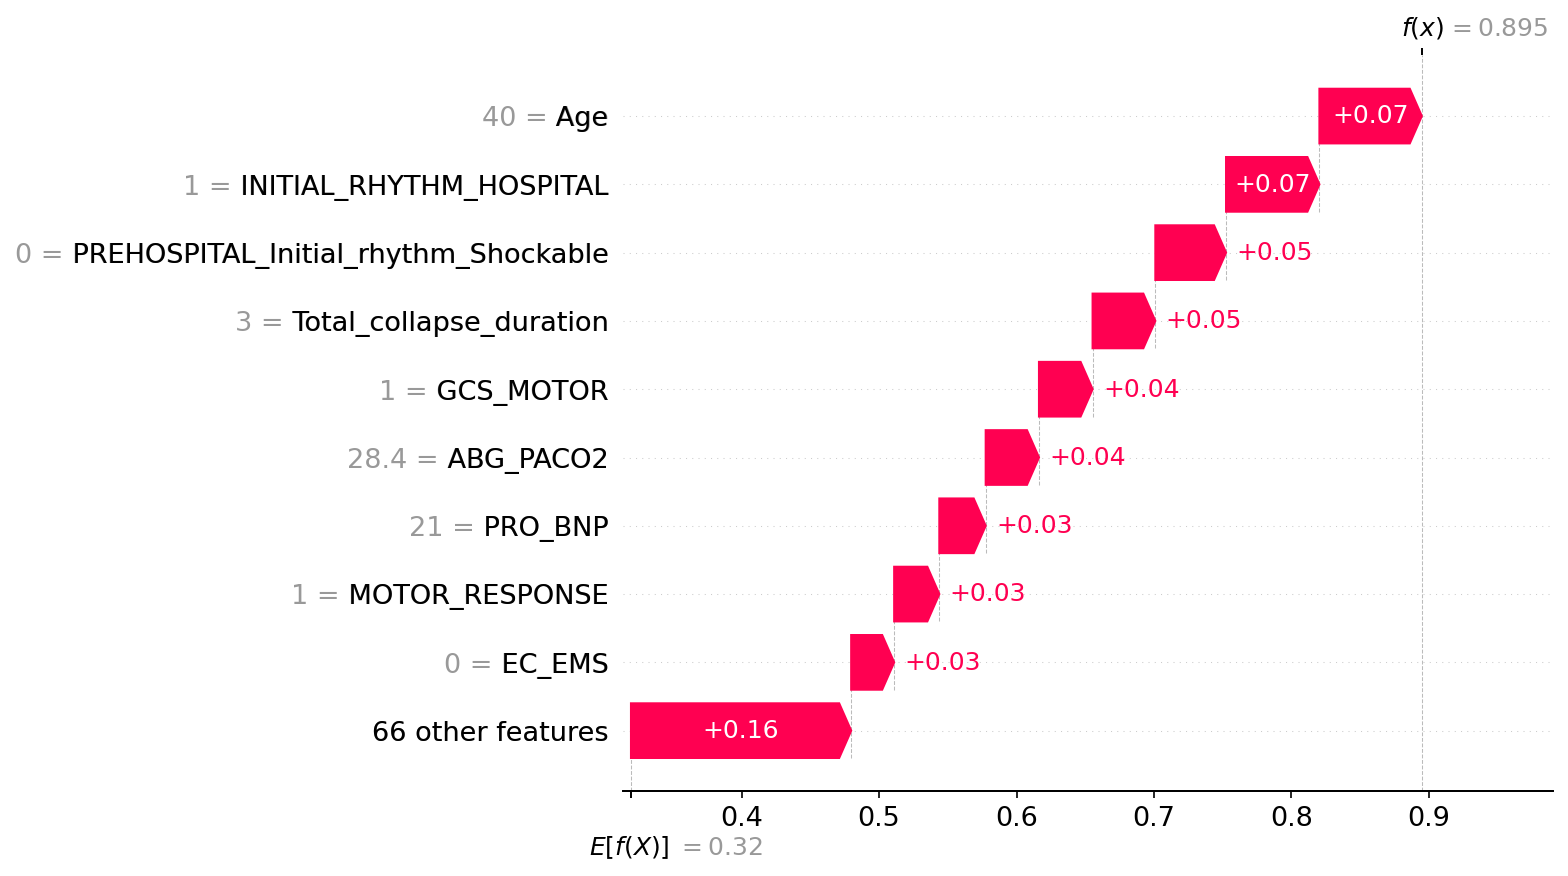

In [349]:
shap.plots.waterfall(shap_values_positive_test[0])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


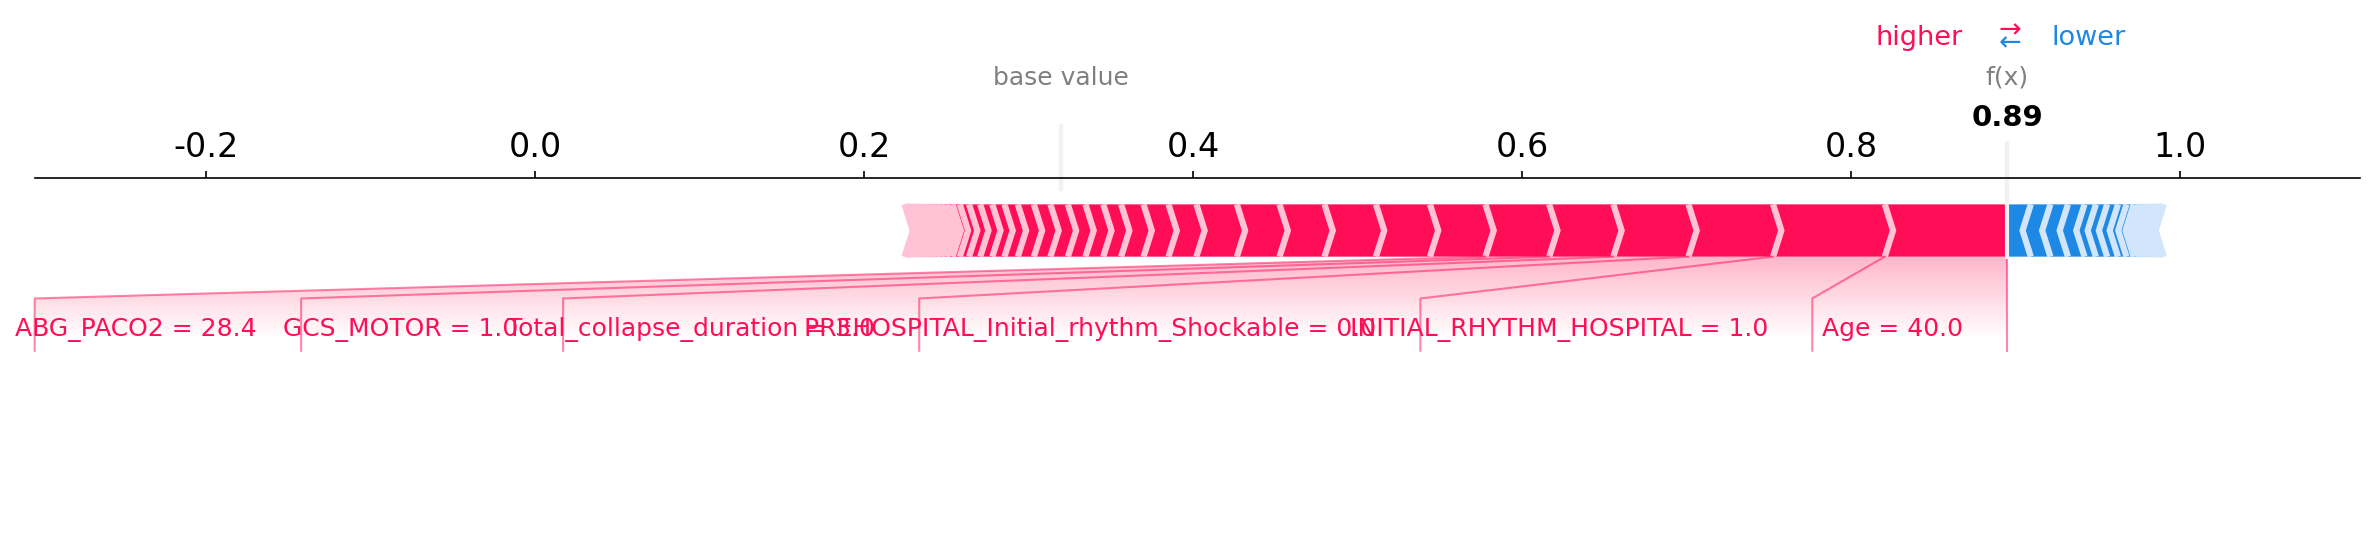

In [351]:
shap.force_plot(shap_values_positive_test[0], matplotlib=True)

##### Predicted survival probability for acutal survivors and non-survivors

In [ ]:
# actual_survivors_dict = {1:None, 2:None, 3:None, 4:None}
# actual_nonsurvivors_dict = {1:None, 2:None, 3:None, 4:None}
# actual_survivors1 = []
# actual_nonsurvivors1 = []
# actual_survivors2 = []
# actual_nonsurvivors2 = []
# actual_survivors3 = []
# actual_nonsurvivors3 = []
# actual_survivors4 = []
# actual_nonsurvivors4 = []
# for i, (clf1, clf2, clf3, clf4) in enumerate(zip(rlr_clfs, rf_clfs, xgb_clfs, en_clfs)) :
    
#     pred1 = clf1.predict_proba(XTests[i])
#     actual_survivors_args = np.where(yTests[i] == 1)[0]
#     actual_nonsurvivors_args = np.where(yTests[i] == 0)[0]
#     actual_survivors1.extend(pred1[:,1][actual_survivors_args])
#     actual_nonsurvivors1.extend(pred1[:,1][actual_nonsurvivors_args])
    
#     pred2 = clf2.predict_proba(XTests[i])
#     actual_survivors_args = np.where(yTests[i] == 1)[0]
#     actual_nonsurvivors_args = np.where(yTests[i] == 0)[0]
#     actual_survivors2.extend(pred2[:,1][actual_survivors_args])
#     actual_nonsurvivors2.extend(pred2[:,1][actual_nonsurvivors_args])
    
#     pred3 = clf3.predict_proba(XTests[i])
#     actual_survivors_args = np.where(yTests[i] == 1)[0]
#     actual_nonsurvivors_args = np.where(yTests[i] == 0)[0]
#     actual_survivors3.extend(pred3[:,1][actual_survivors_args])
#     actual_nonsurvivors3.extend(pred3[:,1][actual_nonsurvivors_args])
    
#     pred4 = clf4.predict_proba(XTests[i])
#     actual_survivors_args = np.where(yTests[i] == 1)[0]
#     actual_nonsurvivors_args = np.where(yTests[i] == 0)[0]
#     actual_survivors4.extend(pred4[:,1][actual_survivors_args])
#     actual_nonsurvivors4.extend(pred4[:,1][actual_nonsurvivors_args])
    
# actual_survivors_dict[1] = actual_survivors1
# actual_nonsurvivors_dict[1] = actual_nonsurvivors1
# actual_survivors_dict[2] = actual_survivors2
# actual_nonsurvivors_dict[2] = actual_nonsurvivors2
# actual_survivors_dict[3] = actual_survivors3
# actual_nonsurvivors_dict[3] = actual_nonsurvivors3
# actual_survivors_dict[4] = actual_survivors4
# actual_nonsurvivors_dict[4] = actual_nonsurvivors4

##### plotting

In [ ]:
# kde1_args = {'bw':0.07, 'color':'silver', "ls":"-", "lw":1}
# hist1_args = {'color':'silver'}
# kde2_args = {'bw':0.01, 'color':'black', "ls":"--", "lw":1}
# hist2_args = {'color':'black'}
# fig, axes = plt.subplots(2, 2, figsize=(8,6.7))
# minor_ticks = np.arange(0, 1, 0.125)
# # Regularized logistic regression
# for i in range(0, 4) : 
#     r, c = int(i/2), int(i%2)
#     sns.distplot(actual_nonsurvivors_dict[i+1], ax=axes[r,c], 
#                  hist_kws=hist2_args, label='Neurologically poor (class 0)',
#                  kde_kws=kde2_args)
#     sns.distplot(actual_survivors_dict[i+1], ax=axes[r,c],
#                  hist_kws=hist1_args, kde_kws=kde1_args,
#                  #axlabel="Predicted survival probability", 
#                  label='Neurologically good (class 1)')
    
#     axes[r,c].set_xlim(-0.2, 1.2)
#     axes[r,c].legend(columnspacing=1, labelspacing=0.1, fontsize=11)
#     if c == 0 :
#         axes[r,c].set_ylabel("Density", fontsize=12)
#     axes[r,c].tick_params(labelsize = 12)
#     axes[r,c].set_title(model_seqs[i]+modelnames[i]+"   N(class 0) = 1126.5,  N(class 1) = 21.5",
#                         loc='left', fontsize=11)
#     if r == 1 :
#         axes[r,c].set_xlabel("Probability", fontsize=12)
#     axes[r,c].set_xticks(minor_ticks, minor=True)
#     axes[r,c].legend(fontsize=11)
    
# plt.subplots_adjust(hspace=0, wspace=0)
# plt.tight_layout()
# png1 = BytesIO()
# plt.savefig(png1, format='png')

# # load this image into PIL
# png2 = Image.open(png1)
# #save as TIFF
# png2.save('Figures/figure3.tif')
# png1.close()
# png2.close()
# plt.savefig("Figures/figure3")
# plt.show()

##### Predicted survival percentage by age group

In [ ]:
# bins = [0, 1, 2, 3, 5, 8, 15, 100000]
# #labels = ["0","1","2", "3", "5", "8", ">15"]
# labels = ["0-1","1-2","2-3", "3-5", "5-8", "8-15", ">=15"]
# for i, (clf1, clf2, clf3, clf4) in enumerate(zip(rlr_clfs, rf_clfs, xgb_clfs, en_clfs)) :
#     pred1 = clf1.predict_proba(XTests[i])
#     pred1_done = adjusted_classes(pred1[:,1], rlr_thr)
#     pred2 = clf2.predict_proba(XTests[i])
#     pred2_done = adjusted_classes(pred2[:,1], rf_thr)
#     pred3 = clf3.predict_proba(XTests[i])
#     pred3_done = adjusted_classes(pred3[:,1], xgb_thr)
#     pred4 = clf4.predict_proba(XTests[i])
#     pred4_done = adjusted_classes(pred4[:,1], en_thr)
#     patients_NFT = pd.DataFrame(XTests[i][:,-1])
#     patients_NFT.columns = ["NFT"]
#     patients_NFT['NFTC'] = pd.cut(patients_NFT['NFT'], bins=bins, labels=labels,
#                                  include_lowest=True, right=False)
#     patients_NFT['TRUE'] = yTests[i]
#     patients_NFT['RLR'] = pred1_done
#     patients_NFT['RF'] = pred2_done
#     patients_NFT['XGB'] = pred3_done
#     patients_NFT['VC'] = pred4_done
#     cntdf = pd.DataFrame(patients_NFT['NFTC'].value_counts())
#     cntdf.columns = ["cnt"]
#     ydf = pd.DataFrame(patients_NFT.groupby('NFTC')[
#                        'TRUE', 'RLR','RF', 'XGB', 'VC'].sum())
#     if i == 0 :
#         summarized = pd.merge(cntdf, ydf, left_index=True, right_index=True, how='right')
#     else :
#         summary = pd.merge(cntdf, ydf, left_index=True, right_index=True, how='right')
#         summarized += summary
# pspag_df = summarized[['TRUE', 'RLR', 'RF', 'XGB', 'VC']].div(summarized['cnt'], axis=0)

In [ ]:
# nftdf = pspag_df.reset_index()

In [ ]:
# nftdf

In [ ]:
# nftdf_melted = pd.melt(nftdf, id_vars=['NFTC'], var_name='methods', 
#                        value_name='Ratio (HCB=1)')

In [ ]:
# sns.set(font_scale = 1.3, style="ticks", palette="muted")

# sns.relplot(x='NFTC', y='Ratio (HCB=1)', hue='methods', 
#             kind='line', legend='full', data=nftdf_melted, 
#             height=5.7, aspect=11.7/8.27)

In [ ]:
# bins = [0, 30, 40, 50, 60, 70, 80, 120]
# labels = ["0-29","30-39","40-49", "50-59", "60-69", "70-79", "80+"]
# #student['grade_cat'] = pd.cut(student['grade'], bins=bins, labels=labels)

# for i, (clf1, clf2, clf3, clf4) in enumerate(zip(rlr_clfs, rf_clfs, xgb_clfs, en_clfs)) :
#     pred1 = clf1.predict_proba(XTests[i])
#     pred1_done = adjusted_classes(pred1[:,1], rlr_thr)
#     pred2 = clf2.predict_proba(XTests[i])
#     pred2_done = adjusted_classes(pred2[:,1], rf_thr)
#     pred3 = clf3.predict_proba(XTests[i])
#     pred3_done = adjusted_classes(pred3[:,1], xgb_thr)
#     pred4 = clf4.predict_proba(XTests[i])
#     pred4_done = adjusted_classes(pred4[:,1], en_thr)
#     patients_age = pd.DataFrame(XTests[i][:,0])
#     patients_age.columns = ["age"]
#     patients_age['age_cat'] = pd.cut(patients_age['age'], bins=bins, labels=labels)
#     patients_age['ylabel'] = yTests[i]
#     patients_age['rlr'] = pred1_done
#     patients_age['rf'] = pred2_done
#     patients_age['xgb'] = pred3_done
#     patients_age['vc'] = pred4_done
#     cntdf = pd.DataFrame(patients_age['age_cat'].value_counts())
#     cntdf.columns = ["cnt"]
#     ydf = pd.DataFrame(patients_age.groupby('age_cat')['ylabel', 'rlr',
#                                                        'rf', 'xgb', 'vc'].sum())
#     #patients_age['age_cat'].value_counts().plot(kind='bar')
#     #print(cntdf)
#     if i == 0 :
#         summarized = pd.merge(cntdf, ydf, left_index=True, right_index=True, how='right')
#     else :
#         summary = pd.merge(cntdf, ydf, left_index=True, right_index=True, how='right')
#         summarized += summary

# #Predicted survival percentage age group df
# pspag_df = summarized[['ylabel', 'rlr', 'rf', 'xgb', 'vc']].div(summarized['cnt'], axis=0)

##### Plotting for predicted survival percentage age group

In [ ]:
# N = 7
# survival = tuple(pspag_df['ylabel'])
# survival_rlr = tuple(pspag_df['rlr'])
# survival_rf = tuple(pspag_df['rf'])
# survival_xgb = tuple(pspag_df['xgb'])
# survival_en = tuple(pspag_df['vc'])

# ind = np.arange(N)  # the x locations for the groups
# width = 0.1      # the width of the bars

# fig, ax = plt.subplots(figsize=(11, 4))
# rects1 = ax.bar(ind, survival, width, color = 'C0', label="Actual")#, hatch="")
# rects2 = ax.bar(ind+width, survival_rlr, width, color = 'C1', label="RLR")#, hatch="+")
# rects3 = ax.bar(ind+2*width, survival_rf, width, color='C3', label="RF")#, hatch="/")
# rects4 = ax.bar(ind+3*width, survival_xgb, width, color='C9', label="XGB")#, hatch="*")
# rects5 = ax.bar(ind+4*width, survival_en, width, color='C5', label="VC")#, hatch="o")


# # add some text for labels, title and axes ticks
# ax.set_ylabel('Ratio', fontsize=15)
# ax.set_xlabel('Age group', fontsize=15)
# ax.set_title('The ratio of predicted good neurologic outcome for age group by ML models',
#              fontsize=15)
# ax.set_xticks(ind + 3*width )
# ax.set_xticklabels(('0-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+'), 
#                   fontsize=15)
# ax.legend(fontsize=15)
# ax.tick_params(labelsize = 15)
# ax.tick_params(axis='y', which='major', labelsize=15)
# ax.tick_params(axis='y', which='major', labelsize=15)

# def autolabel(rects):
#     """
#     Attach a text label above each bar displaying its height
#     """
#     for rect in rects:
#         height = rect.get_height()
#         ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
#                 '%.3f' % int(height),
#                 ha='center', va='bottom')

# # autolabel(rects1)
# # autolabel(rects2)
# # autolabel(rects3)
# # autolabel(rects4)
# # autolabel(rects5)
# # autolabel(rects6)
# plt.tight_layout()
# png1 = BytesIO()
# plt.savefig(png1, format='png')

# # load this image into PIL
# png2 = Image.open(png1)
# #save as TIFF
# png2.save('Figures/figure4.tif')
# png1.close()
# png2.close()
# plt.savefig("Figures/figure4")
# plt.show()

In [ ]:
# rlr_predgood = []
# rf_predgood = []
# xgb_predgood = []
# vc_predgood = []
# for i, (clf1, clf2, clf3, clf4) in enumerate(zip(rlr_clfs, rf_clfs, xgb_clfs, en_clfs)) :
#     pred1 = clf1.predict_proba(XTests[i])
#     pred1_done = adjusted_classes(pred1[:,1], rlr_thr)
#     pred2 = clf2.predict_proba(XTests[i])
#     pred2_done = adjusted_classes(pred2[:,1], rf_thr)
#     pred3 = clf3.predict_proba(XTests[i])
#     pred3_done = adjusted_classes(pred3[:,1], xgb_thr)
#     pred4 = clf4.predict_proba(XTests[i])
#     pred4_done = adjusted_classes(pred4[:,1], en_thr)
#     rlr_predgood.append(pred1_done.count(1)/len(pred1_done))
#     rf_predgood.append(pred2_done.count(1)/len(pred2_done))
#     xgb_predgood.append(pred3_done.count(1)/len(pred3_done))
#     vc_predgood.append(pred4_done.count(1)/len(pred4_done))
#      #, pred2_done, pred3_done, pred4_done, pred5_done)

In [ ]:
# auc_loss = pd.DataFrame(columns=["models", "Predicted Good Neurologic Outcome", 
#                                  "AUC (95% CI)", "BrierLoss (95% CI)", "LogLoss (95% CI)"])
# auc_loss.loc[len(auc_loss)]=["RLR", mean_confidence_interval(rlr_predgood), 
#                              mean_confidence_interval(rlr_aucs), 
#                              mean_confidence_interval(rlr_brier_loss), 
#                              mean_confidence_interval(rlr_log_loss)]
# auc_loss.loc[len(auc_loss)]=["RF", mean_confidence_interval(rf_predgood), 
#                              mean_confidence_interval(rf_aucs),
#                              mean_confidence_interval(rf_brier_loss),
#                              mean_confidence_interval(rf_log_loss)]
# auc_loss.loc[len(auc_loss)]=["XGB", mean_confidence_interval(xgb_predgood), 
#                              mean_confidence_interval(xgb_aucs),
#                              mean_confidence_interval(xgb_brier_loss), 
#                              mean_confidence_interval(xgb_log_loss)]
# auc_loss.loc[len(auc_loss)]=["VC", mean_confidence_interval(vc_predgood), 
#                              mean_confidence_interval(en_aucs), 
#                              mean_confidence_interval(en_brier_loss),
#                              mean_confidence_interval(en_log_loss)]
# # #
# auc_loss.to_csv("table4.csv", index=False)

##### Explainability of Model by LIME

In [ ]:
# # what features?
# df.rename(columns={"TOTAL_RES_DURATION": "TOTAL_DUR", 
#                    "PRE_HOSP_RES_DURATION": "PRE_HOSP_DUR",
#                    "HOSP_RES_DURATION":"HOSP_DUR"}, inplace=True)
# features = df.columns
# Xfeatures = features[1:]
# print(Xfeatures, len(Xfeatures))

# # which one is categorical variables?
# categorical_features = np.argwhere(
#     np.array([len(set(XTests[0][:,i]))
#     for i in range(XTests[0].shape[1])]) <= 20).flatten()
# categorical_features

In [ ]:
# from lime import lime_tabular

# explainer = lime_tabular.LimeTabularExplainer(XTests[0], 
#                                               feature_names=Xfeatures, 
#                                               class_names=['Negative', "Positive"], 
#                                               categorical_features=categorical_features, 
#                                               verbose=False, mode='classification')

# print("positive observation")
# print(np.where(yTests[0] == 1))
# print("positive prediction ")
# pred4 = xgb_clfs[0].predict_proba(XTests[0])
# pred4_done = np.array(adjusted_classes(pred4[:,1], xgb_thr))
# print(np.where(pred4_done == 1))

In [ ]:
# plt.rcParams["font.size"] = 11
# plt.rcParams["font.family"] = "Times New Roman"
# major_ticks = np.arange(-0.05, 0.06,0.025)
# # manual bar plot
# fig = plt.figure(figsize=(8.11, 5.9))    
# #fig.suptitle('Explainability of neurologic outcome', x = 0.59, y = 1.02, fontsize=9)
# # prediction = 0, actual = 0
# i = 103
# np.random.seed(3)
# print ("index = ", i, "label = ", yTests[0][i])
# exp = explainer.explain_instance(XTests[0][i], xgb_clfs[0].predict_proba, num_features=6,
#                                  labels=(1,))
# print("score : ", exp.score)
# exp.show_in_notebook(show_table=True)
# datalist = exp.as_list()
# df_lime = pd.DataFrame(datalist, columns=['crits', 'weight'])
# df_lime['positive'] = df_lime['weight'] > 0
# df_lime.set_index('crits', inplace=True)
# df_lime.index.name = None
# ax1 = fig.add_subplot(2, 2, 1) 
# df_lime['weight'].plot(kind = 'barh', x = [], fontsize=11, title = "a. True-negative",
#                       ax = ax1, xticks = [-0.02, -0.01, 0, 0.01, 0.02], zorder=1, width=0.7, 
#                       color = df_lime.positive.map({True: 'silver', False: 'black'}))
# ax1.set_xticklabels(["–0.02", "–0.01", "0", "0.1", "0.2"])
# ax1.set_yticklabels(["PRE_ECG = 3", "HOSP_ECG = 3", "AGE > 80", 
#                      "55 < TOTAL_DUR <= 70", "WITNESS = 1", "BYCPR = 1"])
# ax1.title.set_size(13)
# #ax1.set_title("A. PRED:0, ACTUAL:0", fontname='Times New Roman', fontsize=12)
# print("")
# # prediction = 1, actual = 1
# i = 1127
# #np.random.seed(1)
# print ("index = ", i, "label = ", yTests[0][i])
# exp = explainer.explain_instance(XTests[0][i], xgb_clfs[0].predict_proba, num_features=6, 
#                                  labels=(1,))
# print("score : ", exp.score)
# exp.show_in_notebook(show_table=True)
# datalist = exp.as_list()
# df_lime = pd.DataFrame(datalist, columns=['crits', 'weight'])
# df_lime['positive'] = df_lime['weight'] > 0
# df_lime.set_index('crits', inplace=True)
# df_lime.index.name = None
# ax2 = fig.add_subplot(2, 2, 2) 
# df_lime['weight'].plot(kind = 'barh', x = [], fontsize=11, title = "b. True-positive",
#                        ax = ax2, xticks = [-0.02, -0.01, 0, 0.01, 0.02],zorder=1, width=0.7, 
#                        color = df_lime.positive.map({True: 'silver', False: 'black'}))
# ax2.set_xticklabels(["–0.02", "–0.01", "0", "0.1", "0.2"])
# ax2.set_yticklabels(["TOTAL_DUR <= 41", "HOSP_DUR <= 11", "PRE_ECG = 2", 
#                      "AGE > 80", "HOSP_ECG = 2", "WITNESS = 1"])
# ax2.title.set_size(13)
# print("")
# # prediction = 0, actual = 1
# i = 1139
# #np.random.seed(1)
# print ("index = ", i, "label = ", yTests[0][i])
# exp = explainer.explain_instance(XTests[0][i], xgb_clfs[0].predict_proba, num_features=6)
# print("score : ", exp.score)
# exp.show_in_notebook(show_table=True)
# datalist = exp.as_list()
# df_lime = pd.DataFrame(datalist, columns=['crits', 'weight'])
# df_lime['positive'] = df_lime['weight'] > 0
# df_lime.set_index('crits', inplace=True)
# df_lime.index.name = None
# #print(df_lime)
# ax3 = fig.add_subplot(2, 2, 3) 
# #ax3.sex_xtickmarks([-0.075, -0.025, 0, 0.025, 0.075])
# #x3.set_xticklabels()
# df_lime['weight'].plot(kind = 'barh', x = [], fontsize=11, title = "c. False-negative",
#                        ax = ax3, xticks = [-0.02, -0.01, 0, 0.01, 0.02],zorder=1, width=0.7, 
#                        #hatch = df_lime.positive.map({True:'+', False:'-'}))
#                        color = df_lime.positive.map({True: 'silver', False: 'black'}))
# ax3.set_xticklabels(["–0.02", "–0.01", "0", "0.1", "0.2"])
# ax3.set_yticklabels(["TOTAL_DUR <= 41", "PRE_ECG = 3", "HOSP_DUR <= 11", 
#                      "HOSP_ECG = 3", "EPINE_TOT <= 3", "BYCPR = 1"])
# ax3.title.set_size(13)


# # prediction = 1, actual = 0
# i = 115
# #np.random.seed(1)
# print ("index = ", i, "label = ", yTests[0][i])
# exp = explainer.explain_instance(XTests[0][i], xgb_clfs[0].predict_proba, num_features=6)
# print("score : ", exp.score)
# exp.show_in_notebook(show_table=True)

# datalist = exp.as_list()
# df_lime = pd.DataFrame(datalist, columns=['crits', 'weight'])
# df_lime['positive'] = df_lime['weight'] > 0
# df_lime.set_index('crits', inplace=True)
# df_lime.index.name = None
# ax4 = fig.add_subplot(2, 2, 4) 
# df_lime['weight'].plot(kind = 'barh', x = [], fontsize=11, title = "d. False-positive",
#                        ax = ax4, xticks = [-0.02, -0.01, 0, 0.01, 0.02], zorder=1, width=0.7, 
#                        color = df_lime.positive.map({True: 'silver', False: 'black'}))
# ax4.set_xticklabels(["–0.02", "–0.01", "0", "0.1", "0.2"])
# ax4.set_yticklabels(["PRE_ECG = 0", "AGE <= 55", "HOSP_ECG = 3", 
#                      "BYCPR = 1", "WITNESS = 1", "PRE_HOSP_DUR > 35"])
# ax4.title.set_size(13)
# plt.tight_layout()
# png1 = BytesIO()
# plt.savefig(png1, format='png', bbox_inches="tight")

# # # load this image into PIL
# png2 = Image.open(png1)
# #save as TIFF
# png2.save('Figures/figure4.tif', bbox_inches="tight")
# png1.close()
# png2.close()
# plt.savefig("Figures/figure4", bbox_inches="tight")
# plt.show()